# LSTM Model

Setup & Imports 

In [1]:
"""
=====================================================================
LSTM MODEL (4 CLASSES) - SECTION 1: SETUP & IMPORTS
=====================================================================
Updated to handle all 4 sentiment classes: positive, negative, neutral, conflict
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import json

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Progress bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("LSTM MODEL (4 CLASSES) - SECTION 1: SETUP & IMPORTS")
print("="*70)

# ============================================================================
# 1. DOWNLOAD NLTK DATA
# ============================================================================
print("\n[1/4] Downloading NLTK data...")

try:
    nltk.data.find('tokenizers/punkt')
    print("✓ punkt already downloaded")
except LookupError:
    nltk.download('punkt', quiet=True)
    print("✓ punkt downloaded")

try:
    nltk.data.find('corpora/stopwords')
    print("✓ stopwords already downloaded")
except LookupError:
    nltk.download('stopwords', quiet=True)
    print("✓ stopwords downloaded")

# ============================================================================
# 2. SET RANDOM SEEDS
# ============================================================================
print("\n[2/4] Setting random seeds for reproducibility...")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"✓ Random seed set to {SEED}")

# ============================================================================
# 3. SET DEVICE
# ============================================================================
print("\n[3/4] Checking device availability...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================================================
# 4. CREATE DIRECTORIES
# ============================================================================
print("\n[4/4] Creating project directories...")

directories = [
    '../data/processed',
    '../models/lstm',
    '../results/figures/lstm',
    '../results/reports',
    '../logs'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ {directory}")

# ============================================================================
# CONFIGURATION
# ============================================================================
print("\n" + "="*70)
print("CONFIGURATION (4 CLASSES)")
print("="*70)

config = {
    'num_classes': 4,  # ⭐ IMPORTANT: 4 classes now!
    'classes': ['positive', 'negative', 'neutral', 'conflict'],
    'max_length': 100,
    'embedding_dim': 100,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.3,
    'batch_size': 32,
    'epochs': 20,
    'learning_rate': 0.001,
    'patience': 5
}

print(f"Number of Classes: {config['num_classes']}")
print(f"Classes: {config['classes']}")
print(f"Max Sequence Length: {config['max_length']}")
print(f"Embedding Dim: {config['embedding_dim']}")
print(f"Hidden Dim: {config['hidden_dim']}")
print(f"Batch Size: {config['batch_size']}")
print(f"Epochs: {config['epochs']}")

print("\n" + "="*70)
print("SETUP COMPLETE!")
print("="*70)
print("\n✅ Ready for Section 2 (Data Loading)")

LSTM MODEL (4 CLASSES) - SECTION 1: SETUP & IMPORTS

[1/4] Downloading NLTK data...
✓ punkt already downloaded
✓ stopwords already downloaded

[2/4] Setting random seeds for reproducibility...
✓ Random seed set to 42

[3/4] Checking device availability...
✓ Using device: cpu

[4/4] Creating project directories...
✓ ../data/processed
✓ ../models/lstm
✓ ../results/figures/lstm
✓ ../results/reports
✓ ../logs

CONFIGURATION (4 CLASSES)
Number of Classes: 4
Classes: ['positive', 'negative', 'neutral', 'conflict']
Max Sequence Length: 100
Embedding Dim: 100
Hidden Dim: 128
Batch Size: 32
Epochs: 20

SETUP COMPLETE!

✅ Ready for Section 2 (Data Loading)


Data Loading & EDA

SECTION 2: DATA LOADING & EDA (4 CLASSES)

[1/6] Loading training data...
✓ Training data loaded: (2358, 6)
  Columns: ['id', 'Sentence', 'Aspect Term', 'polarity', 'from', 'to']

[2/6] Inspecting data...

First 5 rows:
     id                                           Sentence     Aspect Term  \
0  2339  I charge it at night and skip taking the cord ...            cord   
1  2339  I charge it at night and skip taking the cord ...    battery life   
2  1316  The tech guy then said the service center does...  service center   
3  1316  The tech guy then said the service center does...    "sales" team   
4  1316  The tech guy then said the service center does...        tech guy   

   polarity  from   to  
0   neutral    41   45  
1  positive    74   86  
2  negative    27   41  
3  negative   109  121  
4   neutral     4   12  

Data types:
id              int64
Sentence       object
Aspect Term    object
polarity       object
from            int64
to              int64
dtype: object

M

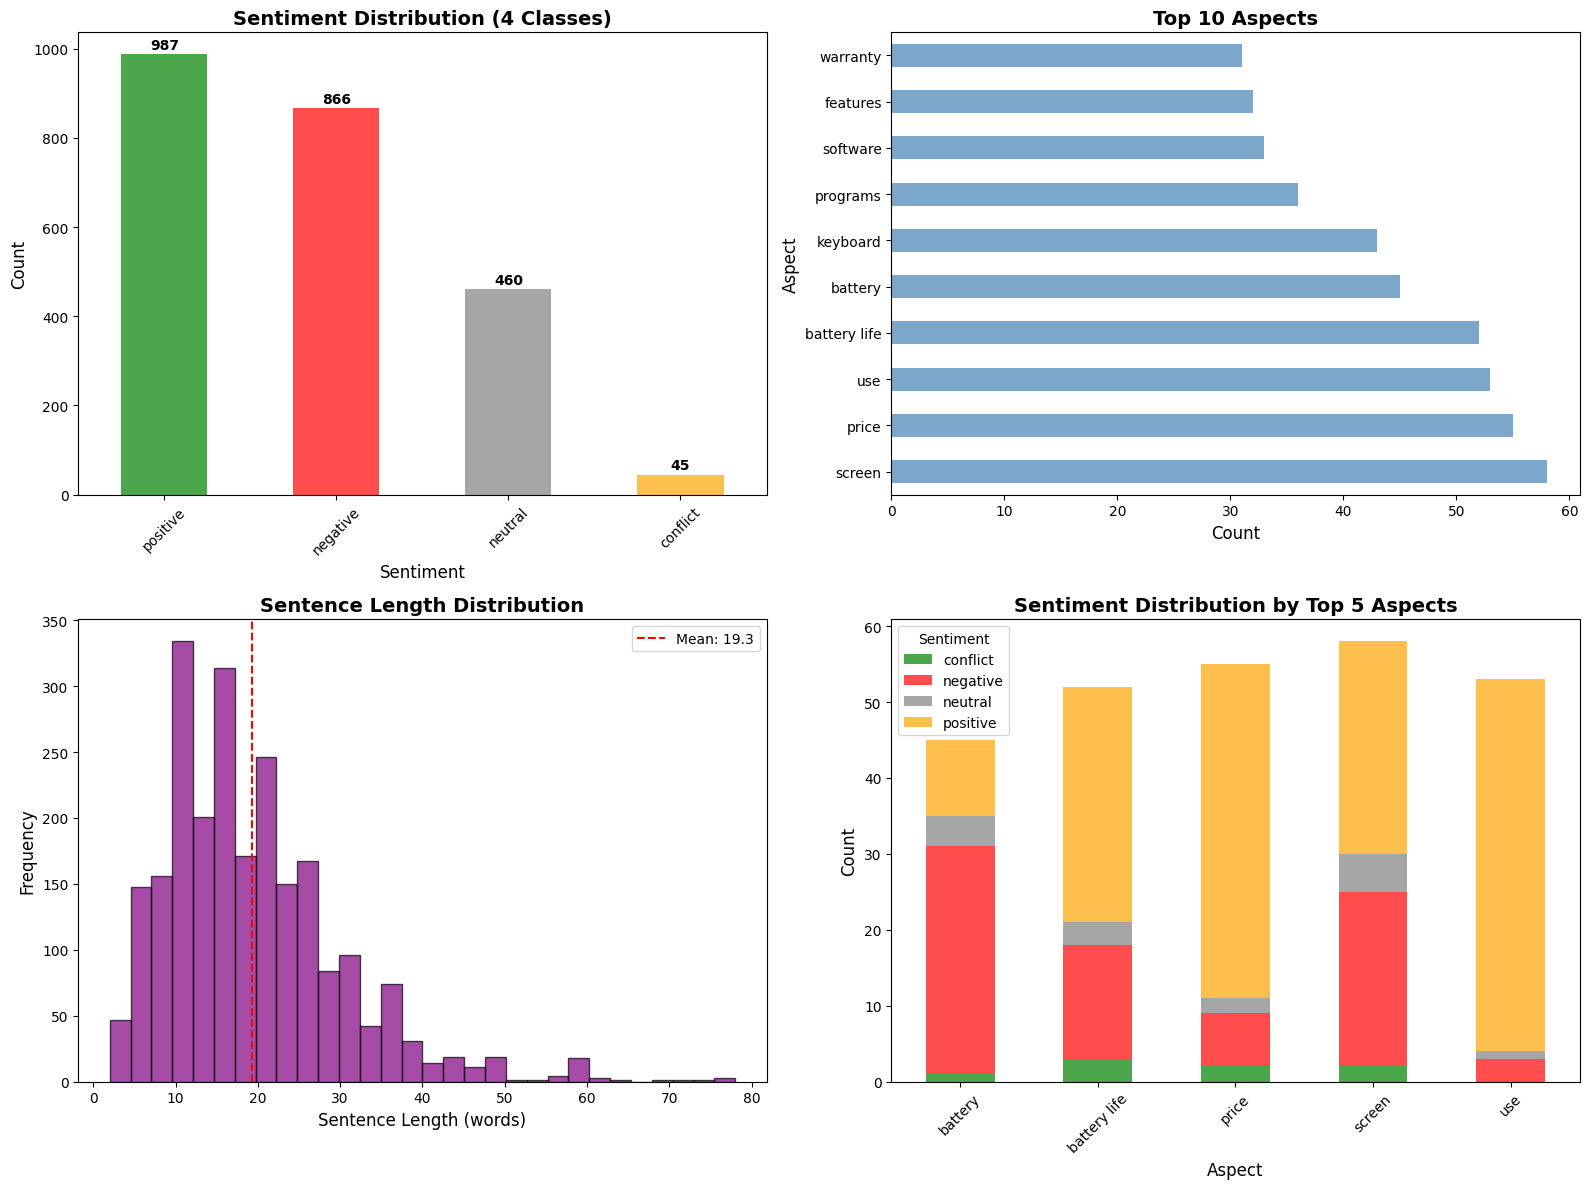

✓ Visualizations saved

Saving EDA statistics...
✓ EDA statistics saved

DATA LOADING & EDA COMPLETE!

✅ Total Samples: 2358
✅ Number of Classes: 4 (Expected: 4)
✅ Classes: positive, negative, neutral, conflict

✅ Ready for Section 3 (Preprocessing)


In [2]:
"""
=====================================================================
LSTM MODEL (4 CLASSES) - SECTION 2: DATA LOADING & EDA
=====================================================================
"""

print("="*70)
print("SECTION 2: DATA LOADING & EDA (4 CLASSES)")
print("="*70)

# ============================================================================
# 1. LOAD TRAINING DATA
# ============================================================================
print("\n[1/6] Loading training data...")

train_df = pd.read_csv('../data/raw/Laptop_Train_v2.csv')

print(f"✓ Training data loaded: {train_df.shape}")
print(f"  Columns: {list(train_df.columns)}")

# ============================================================================
# 2. DATA INSPECTION
# ============================================================================
print("\n[2/6] Inspecting data...")

print("\nFirst 5 rows:")
print(train_df.head())

print("\nData types:")
print(train_df.dtypes)

print("\nMissing values:")
print(train_df.isnull().sum())

# ============================================================================
# 3. SENTIMENT DISTRIBUTION (4 CLASSES)
# ============================================================================
print("\n[3/6] Analyzing sentiment distribution...")

sentiment_counts = train_df['polarity'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print(f"\nTotal samples: {len(train_df)}")

# Check if all 4 classes present
expected_classes = ['positive', 'negative', 'neutral', 'conflict']
present_classes = sentiment_counts.index.tolist()

print(f"\n✓ Classes in dataset: {present_classes}")
print(f"  Expected 4 classes: {expected_classes}")

if len(present_classes) == 4:
    print("✅ All 4 classes present!")
else:
    print(f"⚠ Warning: Only {len(present_classes)} classes found!")
    
# ============================================================================
# 4. ASPECT DISTRIBUTION
# ============================================================================
print("\n[4/6] Analyzing aspects...")

aspect_counts = train_df['Aspect Term'].value_counts().head(10)
print("\nTop 10 Aspects:")
print(aspect_counts)

# ============================================================================
# 5. SENTENCE LENGTH ANALYSIS
# ============================================================================
print("\n[5/6] Analyzing sentence lengths...")

train_df['sentence_length'] = train_df['Sentence'].apply(lambda x: len(str(x).split()))

print(f"\nSentence Length Statistics:")
print(f"  Mean: {train_df['sentence_length'].mean():.2f}")
print(f"  Median: {train_df['sentence_length'].median():.2f}")
print(f"  Min: {train_df['sentence_length'].min()}")
print(f"  Max: {train_df['sentence_length'].max()}")
print(f"  Std: {train_df['sentence_length'].std():.2f}")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================
print("\n[6/6] Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Sentiment Distribution
ax1 = axes[0, 0]
sentiment_counts.plot(kind='bar', ax=ax1, color=['green', 'red', 'gray', 'orange'], alpha=0.7)
ax1.set_title('Sentiment Distribution (4 Classes)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(sentiment_counts.values):
    ax1.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 2: Aspect Distribution
ax2 = axes[0, 1]
aspect_counts.plot(kind='barh', ax=ax2, color='steelblue', alpha=0.7)
ax2.set_title('Top 10 Aspects', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Aspect', fontsize=12)

# Plot 3: Sentence Length Distribution
ax3 = axes[1, 0]
ax3.hist(train_df['sentence_length'], bins=30, color='purple', alpha=0.7, edgecolor='black')
ax3.set_title('Sentence Length Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sentence Length (words)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.axvline(train_df['sentence_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {train_df["sentence_length"].mean():.1f}')
ax3.legend()

# Plot 4: Sentiment by Aspect (Top 5)
ax4 = axes[1, 1]
top_5_aspects = train_df['Aspect Term'].value_counts().head(5).index
aspect_sentiment = train_df[train_df['Aspect Term'].isin(top_5_aspects)].groupby(
    ['Aspect Term', 'polarity']).size().unstack(fill_value=0)
aspect_sentiment.plot(kind='bar', stacked=True, ax=ax4, 
                     color=['green', 'red', 'gray', 'orange'], alpha=0.7)
ax4.set_title('Sentiment Distribution by Top 5 Aspects', fontsize=14, fontweight='bold')
ax4.set_xlabel('Aspect', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('../results/figures/lstm/eda_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved")

# ============================================================================
# 7. SAVE EDA STATISTICS
# ============================================================================
print("\nSaving EDA statistics...")

eda_stats = {
    'total_samples': int(len(train_df)),
    'num_classes': int(len(sentiment_counts)),
    'classes': sentiment_counts.index.tolist(),
    'class_distribution': sentiment_counts.to_dict(),
    'sentence_length': {
        'mean': float(train_df['sentence_length'].mean()),
        'median': float(train_df['sentence_length'].median()),
        'min': int(train_df['sentence_length'].min()),
        'max': int(train_df['sentence_length'].max()),
        'std': float(train_df['sentence_length'].std())
    },
    'top_10_aspects': aspect_counts.to_dict()
}

with open('../results/reports/lstm_eda_stats.json', 'w') as f:
    json.dump(eda_stats, f, indent=4)

print("✓ EDA statistics saved")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("DATA LOADING & EDA COMPLETE!")
print("="*70)
print(f"\n✅ Total Samples: {len(train_df)}")
print(f"✅ Number of Classes: {len(sentiment_counts)} (Expected: 4)")
print(f"✅ Classes: {', '.join(sentiment_counts.index.tolist())}")
print(f"\n✅ Ready for Section 3 (Preprocessing)")
print("="*70)

 Preprocessing & Vocabulary

In [3]:
import nltk
import ssl

# Fix SSL issue (if any)
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download properly
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Test
from nltk.tokenize import word_tokenize
print("Test:", word_tokenize("This is a test sentence."))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vyomann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vyomann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vyomann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Test: ['This', 'is', 'a', 'test', 'sentence', '.']


In [4]:
"""
=====================================================================
LSTM MODEL (4 CLASSES) - SECTION 3: PREPROCESSING & VOCABULARY
=====================================================================
"""

import re
from collections import Counter

print("="*70)
print("SECTION 3: PREPROCESSING & VOCABULARY (4 CLASSES)")
print("="*70)

# ============================================================================
# 1. TEXT PREPROCESSING
# ============================================================================
print("\n[1/8] Defining preprocessing functions...")

def preprocess_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters but keep important punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.,!?]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def tokenize_text(text):
    """Tokenize text into words"""
    return word_tokenize(text)

print("✓ Preprocessing functions defined")

# ============================================================================
# 2. APPLY PREPROCESSING
# ============================================================================
print("\n[2/8] Preprocessing training data...")

train_df['cleaned_text'] = train_df['Sentence'].apply(preprocess_text)
train_df['tokens'] = train_df['cleaned_text'].apply(tokenize_text)

print(f"✓ {len(train_df)} sentences preprocessed")

# Show example
print("\nExample:")
print(f"Original: {train_df.iloc[0]['Sentence']}")
print(f"Cleaned:  {train_df.iloc[0]['cleaned_text']}")
print(f"Tokens:   {train_df.iloc[0]['tokens'][:10]}")

# ============================================================================
# 3. BUILD VOCABULARY
# ============================================================================
print("\n[3/8] Building vocabulary...")

# Collect all tokens
all_tokens = []
for tokens in train_df['tokens']:
    all_tokens.extend(tokens)

# Count frequency
token_freq = Counter(all_tokens)
print(f"\n✓ Total tokens: {len(all_tokens)}")
print(f"✓ Unique tokens: {len(token_freq)}")

# Most common tokens
print("\nTop 10 most common tokens:")
for token, freq in token_freq.most_common(10):
    print(f"  {token:15s}: {freq:4d}")

# Create vocabulary (only tokens with freq >= 2)
MIN_FREQ = 2
vocab = {'<PAD>': 0, '<UNK>': 1}
idx = 2

for token, freq in token_freq.items():
    if freq >= MIN_FREQ:
        vocab[token] = idx
        idx += 1

print(f"\n✓ Vocabulary size (freq >= {MIN_FREQ}): {len(vocab)}")
print(f"  <PAD> token: {vocab['<PAD>']}")
print(f"  <UNK> token: {vocab['<UNK>']}")

# ============================================================================
# 4. ENCODE SEQUENCES
# ============================================================================
print("\n[4/8] Encoding sequences...")

def encode_sequence(tokens, vocab, max_length):
    """Convert tokens to indices"""
    encoded = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    
    # Truncate if too long
    if len(encoded) > max_length:
        encoded = encoded[:max_length]
    
    # Pad if too short
    while len(encoded) < max_length:
        encoded.append(vocab['<PAD>'])
    
    return encoded

MAX_LENGTH = config['max_length']
train_df['encoded'] = train_df['tokens'].apply(
    lambda x: encode_sequence(x, vocab, MAX_LENGTH)
)

print(f"✓ Sequences encoded (max_length={MAX_LENGTH})")

# ============================================================================
# 5. ENCODE LABELS (4 CLASSES)
# ============================================================================
print("\n[5/8] Encoding labels (4 classes)...")

label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['polarity'])

print(f"✓ Label encoder created")
print(f"  Classes: {list(label_encoder.classes_)}")
print(f"  Number of classes: {len(label_encoder.classes_)}")

# Verify 4 classes
if len(label_encoder.classes_) != 4:
    print(f"\n⚠ WARNING: Expected 4 classes, got {len(label_encoder.classes_)}")
else:
    print("\n✅ All 4 classes confirmed!")

# Show encoding
print("\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label:10s} → {i}")

# ============================================================================
# 6. TRAIN-VAL-TEST SPLIT
# ============================================================================
print("\n[6/8] Splitting data...")

# Get sequences and labels
sequences = train_df['encoded'].tolist()
labels = train_df['label_encoded'].tolist()

# Split: 70% train, 15% val, 15% test
train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(
    sequences, labels, test_size=0.3, random_state=SEED, stratify=labels
)

val_sequences, test_sequences, val_labels, test_labels = train_test_split(
    temp_sequences, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print(f"✓ Data split complete:")
print(f"  Training:   {len(train_sequences)} samples")
print(f"  Validation: {len(val_sequences)} samples")
print(f"  Test:       {len(test_sequences)} samples")

# Check class distribution
print("\nClass distribution:")
for split_name, split_labels in [('Train', train_labels), 
                                  ('Val', val_labels), 
                                  ('Test', test_labels)]:
    unique, counts = np.unique(split_labels, return_counts=True)
    print(f"\n{split_name}:")
    for label_idx, count in zip(unique, counts):
        label_name = label_encoder.inverse_transform([label_idx])[0]
        print(f"  {label_name:10s}: {count:4d} ({count/len(split_labels)*100:.1f}%)")

# ============================================================================
# 7. SAVE PROCESSED DATA
# ============================================================================
print("\n[7/8] Saving processed data...")

processed_data = {
    'vocab': vocab,
    'label_encoder': label_encoder,
    'train_sequences': train_sequences,
    'val_sequences': val_sequences,
    'test_sequences': test_sequences,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels,
    'max_length': MAX_LENGTH,
    'vocab_size': len(vocab),
    'num_classes': len(label_encoder.classes_)
}

with open('../data/processed/lstm_vocab.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✓ Processed data saved to: data/processed/lstm_vocab.pkl")

# Save vocabulary info
vocab_info = {
    'vocab_size': len(vocab),
    'max_length': MAX_LENGTH,
    'num_classes': len(label_encoder.classes_),
    'classes': list(label_encoder.classes_),
    'train_size': len(train_sequences),
    'val_size': len(val_sequences),
    'test_size': len(test_sequences)
}

with open('../results/reports/lstm_vocabulary.json', 'w') as f:
    json.dump(vocab_info, f, indent=4)

print("✓ Vocabulary info saved")

# ============================================================================
# 8. CREATE PYTORCH DATASET
# ============================================================================
print("\n[8/8] Creating PyTorch datasets...")

class ABSADataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': torch.tensor(self.sequences[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = ABSADataset(train_sequences, train_labels)
val_dataset = ABSADataset(val_sequences, val_labels)
test_dataset = ABSADataset(test_sequences, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                         shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                       shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                        shuffle=False, num_workers=0)

print(f"✓ Datasets created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# Test batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Sequences shape: {sample_batch['sequence'].shape}")
print(f"  Labels shape: {sample_batch['label'].shape}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("PREPROCESSING COMPLETE!")
print("="*70)
print(f"\n✅ Vocabulary size: {len(vocab)}")
print(f"✅ Max sequence length: {MAX_LENGTH}")
print(f"✅ Number of classes: {len(label_encoder.classes_)} (4 expected)")
print(f"✅ Classes: {', '.join(label_encoder.classes_)}")
print(f"\n✅ Datasets ready:")
print(f"   Train: {len(train_dataset)} samples")
print(f"   Val:   {len(val_dataset)} samples")
print(f"   Test:  {len(test_dataset)} samples")
print(f"\n✅ Ready for Section 4 (Model Training)")
print("="*70)

SECTION 3: PREPROCESSING & VOCABULARY (4 CLASSES)

[1/8] Defining preprocessing functions...
✓ Preprocessing functions defined

[2/8] Preprocessing training data...
✓ 2358 sentences preprocessed

Example:
Original: I charge it at night and skip taking the cord with me because of the good battery life.
Cleaned:  i charge it at night and skip taking the cord with me because of the good battery life.
Tokens:   ['i', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord']

[3/8] Building vocabulary...

✓ Total tokens: 50035
✓ Unique tokens: 3197

Top 10 most common tokens:
  the            : 2811
  ,              : 2220
  .              : 2159
  and            : 1610
  to             : 1232
  i              : 1160
  it             : 1029
  a              : 1029
  is             :  908
  of             :  677

✓ Vocabulary size (freq >= 2): 2351
  <PAD> token: 0
  <UNK> token: 1

[4/8] Encoding sequences...
✓ Sequences encoded (max_length=100)

[5/8] Encoding labels (4 classe

 Model & Training 

2025-12-16 23:25:13,344 - INFO - ======================================================================
2025-12-16 23:25:13,423 - INFO - LSTM MODEL (4 CLASSES) - TRAINING STARTED
2025-12-16 23:25:13,423 - INFO - ======================================================================


SECTION 4: MODEL ARCHITECTURE & TRAINING (4 CLASSES)

[1/7] Setting up logging...
✓ Logging configured

[2/7] Defining model architecture...
✓ LSTM model architecture defined

[3/7] Initializing model...


2025-12-16 23:25:13,694 - INFO - Model Configuration: {'vocab_size': 2351, 'embedding_dim': 100, 'hidden_dim': 128, 'output_dim': 4, 'n_layers': 2, 'dropout': 0.3, 'pad_idx': 0}
2025-12-16 23:25:13,694 - INFO - Total parameters: 866,912


✓ Model initialized
  Total parameters: 866,912

[4/7] Setting up loss function and optimizer...

Class weights:
  conflict  : 13.3065 (count: 31)
  negative  : 0.6807 (count: 606)
  neutral   : 1.2811 (count: 322)
  positive  : 0.5970 (count: 691)


2025-12-16 23:25:27,899 - INFO - Training started: 20 epochs


✓ Loss function and optimizer configured

[5/7] Defining training functions...
✓ Training functions defined

[6/7] Starting training...

Training for 20 epochs...
Device: cpu
Classes: 4 (4 expected)


2025-12-16 23:25:35,448 - INFO - Epoch 1: Train Loss=1.3662, Val Loss=1.3606, Val F1=0.2952
2025-12-16 23:25:35,598 - INFO - Best model saved at epoch 1 with F1: 0.2952



Epoch 1/20 (7.5s)
  Train Loss: 1.3662 | Train Acc: 35.65%
  Val Loss:   1.3606 | Val Acc:   42.97% | Val F1: 0.2952
  ✓ Best model saved! (F1: 0.2952)


2025-12-16 23:25:40,832 - INFO - Epoch 2: Train Loss=1.2465, Val Loss=1.3382, Val F1=0.3950
2025-12-16 23:25:40,848 - INFO - Best model saved at epoch 2 with F1: 0.3950



Epoch 2/20 (5.2s)
  Train Loss: 1.2465 | Train Acc: 51.93%
  Val Loss:   1.3382 | Val Acc:   50.78% | Val F1: 0.3950
  ✓ Best model saved! (F1: 0.3950)


2025-12-16 23:25:45,999 - INFO - Epoch 3: Train Loss=1.0174, Val Loss=1.4333, Val F1=0.4446
2025-12-16 23:25:46,023 - INFO - Best model saved at epoch 3 with F1: 0.4446



Epoch 3/20 (5.2s)
  Train Loss: 1.0174 | Train Acc: 56.60%
  Val Loss:   1.4333 | Val Acc:   57.55% | Val F1: 0.4446
  ✓ Best model saved! (F1: 0.4446)


2025-12-16 23:25:51,126 - INFO - Epoch 4: Train Loss=0.8462, Val Loss=1.4496, Val F1=0.3930



Epoch 4/20 (5.1s)
  Train Loss: 0.8462 | Train Acc: 62.09%
  Val Loss:   1.4496 | Val Acc:   51.82% | Val F1: 0.3930
  No improvement (1/5)


2025-12-16 23:25:56,199 - INFO - Epoch 5: Train Loss=0.8341, Val Loss=1.6725, Val F1=0.3983



Epoch 5/20 (5.1s)
  Train Loss: 0.8341 | Train Acc: 64.58%
  Val Loss:   1.6725 | Val Acc:   51.82% | Val F1: 0.3983
  No improvement (2/5)


2025-12-16 23:26:01,299 - INFO - Epoch 6: Train Loss=0.7371, Val Loss=1.4468, Val F1=0.4731
2025-12-16 23:26:01,318 - INFO - Best model saved at epoch 6 with F1: 0.4731



Epoch 6/20 (5.1s)
  Train Loss: 0.7371 | Train Acc: 68.91%
  Val Loss:   1.4468 | Val Acc:   55.47% | Val F1: 0.4731
  ✓ Best model saved! (F1: 0.4731)


2025-12-16 23:26:06,532 - INFO - Epoch 7: Train Loss=0.6462, Val Loss=1.5627, Val F1=0.4857
2025-12-16 23:26:06,548 - INFO - Best model saved at epoch 7 with F1: 0.4857



Epoch 7/20 (5.2s)
  Train Loss: 0.6462 | Train Acc: 72.75%
  Val Loss:   1.5627 | Val Acc:   57.29% | Val F1: 0.4857
  ✓ Best model saved! (F1: 0.4857)


2025-12-16 23:26:11,799 - INFO - Epoch 8: Train Loss=0.5429, Val Loss=1.8166, Val F1=0.4605



Epoch 8/20 (5.3s)
  Train Loss: 0.5429 | Train Acc: 74.48%
  Val Loss:   1.8166 | Val Acc:   57.81% | Val F1: 0.4605
  No improvement (1/5)


2025-12-16 23:26:17,049 - INFO - Epoch 9: Train Loss=0.4922, Val Loss=1.7563, Val F1=0.5067
2025-12-16 23:26:17,065 - INFO - Best model saved at epoch 9 with F1: 0.5067



Epoch 9/20 (5.3s)
  Train Loss: 0.4922 | Train Acc: 77.78%
  Val Loss:   1.7563 | Val Acc:   59.64% | Val F1: 0.5067
  ✓ Best model saved! (F1: 0.5067)


2025-12-16 23:26:22,648 - INFO - Epoch 10: Train Loss=0.5057, Val Loss=2.0597, Val F1=0.5055



Epoch 10/20 (5.6s)
  Train Loss: 0.5057 | Train Acc: 80.57%
  Val Loss:   2.0597 | Val Acc:   59.64% | Val F1: 0.5055
  No improvement (1/5)


2025-12-16 23:26:28,132 - INFO - Epoch 11: Train Loss=0.4229, Val Loss=2.0939, Val F1=0.4782



Epoch 11/20 (5.5s)
  Train Loss: 0.4229 | Train Acc: 82.84%
  Val Loss:   2.0939 | Val Acc:   59.90% | Val F1: 0.4782
  No improvement (2/5)


2025-12-16 23:26:33,349 - INFO - Epoch 12: Train Loss=0.3915, Val Loss=2.2426, Val F1=0.4758



Epoch 12/20 (5.2s)
  Train Loss: 0.3915 | Train Acc: 83.21%
  Val Loss:   2.2426 | Val Acc:   60.42% | Val F1: 0.4758
  No improvement (3/5)


2025-12-16 23:26:38,632 - INFO - Epoch 13: Train Loss=0.3416, Val Loss=2.4350, Val F1=0.4811



Epoch 13/20 (5.3s)
  Train Loss: 0.3416 | Train Acc: 85.04%
  Val Loss:   2.4350 | Val Acc:   60.68% | Val F1: 0.4811
  No improvement (4/5)


2025-12-16 23:26:43,925 - INFO - Epoch 14: Train Loss=0.3284, Val Loss=2.4273, Val F1=0.4647
2025-12-16 23:26:43,926 - INFO - Early stopping at epoch 14
2025-12-16 23:26:43,926 - INFO - Training completed in 1.3 minutes



Epoch 14/20 (5.3s)
  Train Loss: 0.3284 | Train Acc: 85.84%
  Val Loss:   2.4273 | Val Acc:   58.07% | Val F1: 0.4647
  No improvement (5/5)

Early stopping triggered at epoch 14

✓ Training completed in 1.3 minutes

[7/7] Saving training history...


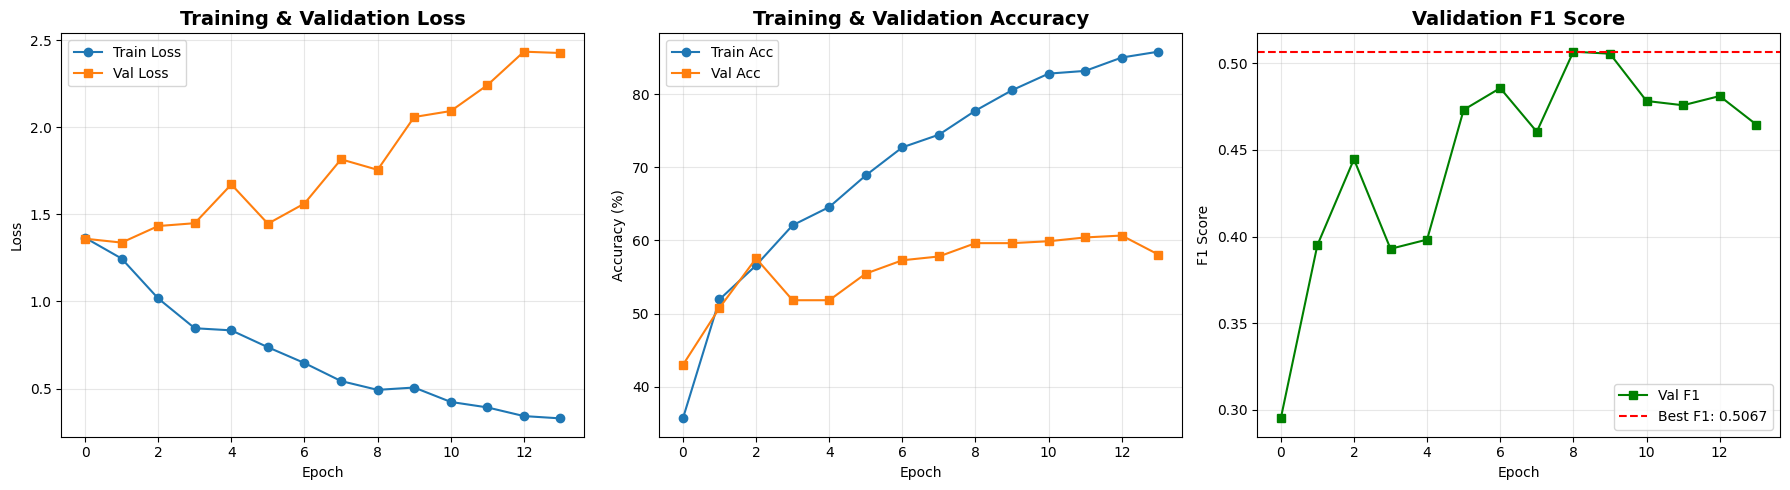

2025-12-16 23:26:44,782 - INFO - ======================================================================
2025-12-16 23:26:44,782 - INFO - Training Summary: Best F1=0.5067, Epochs=14
2025-12-16 23:26:44,782 - INFO - ======================================================================


✓ Training history saved

TRAINING COMPLETE!

✅ Best Validation F1: 0.5067
✅ Total Epochs: 14
✅ Training Time: 1.3 minutes
✅ Model saved: models/lstm/best_lstm_model.pth

✅ Ready for Section 5 (Evaluation)


In [5]:
"""
=====================================================================
LSTM MODEL (4 CLASSES) - SECTION 4: MODEL ARCHITECTURE & TRAINING
=====================================================================
"""

import time
import logging

print("="*70)
print("SECTION 4: MODEL ARCHITECTURE & TRAINING (4 CLASSES)")
print("="*70)

# ============================================================================
# 1. SETUP LOGGING
# ============================================================================
print("\n[1/7] Setting up logging...")

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('../logs/lstm_training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

logger.info("="*70)
logger.info("LSTM MODEL (4 CLASSES) - TRAINING STARTED")
logger.info("="*70)

print("✓ Logging configured")

# ============================================================================
# 2. MODEL ARCHITECTURE
# ============================================================================
print("\n[2/7] Defining model architecture...")

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, dropout, pad_idx):
        super(LSTMClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer (bidirectional so hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text):
        # text: [batch_size, seq_len]
        
        # Embedding
        embedded = self.dropout(self.embedding(text))
        # embedded: [batch_size, seq_len, embedding_dim]
        
        # LSTM
        output, (hidden, cell) = self.lstm(embedded)
        # output: [batch_size, seq_len, hidden_dim * 2]
        # hidden: [n_layers * 2, batch_size, hidden_dim]
        
        # Concatenate final forward and backward hidden states
        hidden_fwd = hidden[-2, :, :]
        hidden_bwd = hidden[-1, :, :]
        hidden_concat = torch.cat([hidden_fwd, hidden_bwd], dim=1)
        # hidden_concat: [batch_size, hidden_dim * 2]
        
        # Apply dropout and pass through FC layer
        output = self.dropout(hidden_concat)
        output = self.fc(output)
        # output: [batch_size, output_dim]
        
        return output

print("✓ LSTM model architecture defined")

# ============================================================================
# 3. INITIALIZE MODEL
# ============================================================================
print("\n[3/7] Initializing model...")

# Model configuration
model_config = {
    'vocab_size': len(vocab),
    'embedding_dim': config['embedding_dim'],
    'hidden_dim': config['hidden_dim'],
    'output_dim': 4,  # ⭐ 4 CLASSES!
    'n_layers': config['num_layers'],
    'dropout': config['dropout'],
    'pad_idx': vocab['<PAD>']
}

# Initialize model
model = LSTMClassifier(**model_config).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized")
print(f"  Total parameters: {count_parameters(model):,}")

logger.info(f"Model Configuration: {model_config}")
logger.info(f"Total parameters: {count_parameters(model):,}")

# ============================================================================
# 4. LOSS & OPTIMIZER
# ============================================================================
print("\n[4/7] Setting up loss function and optimizer...")

# Calculate class weights for imbalanced data
class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_weights = []

print("\nClass weights:")
for i in range(len(label_encoder.classes_)):
    count = class_counts[i]
    weight = total_samples / (len(label_encoder.classes_) * count)
    class_weights.append(weight)
    label_name = label_encoder.inverse_transform([i])[0]
    print(f"  {label_name:10s}: {weight:.4f} (count: {count})")

class_weights = torch.FloatTensor(class_weights).to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

print("✓ Loss function and optimizer configured")

# ============================================================================
# 5. TRAINING FUNCTIONS
# ============================================================================
print("\n[5/7] Defining training functions...")

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in tqdm(loader, desc='Training', leave=False):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        predictions = model(sequences)
        loss = criterion(predictions, labels)
        acc = (predictions.argmax(1) == labels).float().mean()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            predictions = model(sequences)
            loss = criterion(predictions, labels)
            acc = (predictions.argmax(1) == labels).float().mean()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            all_preds.extend(predictions.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss / len(loader), epoch_acc / len(loader), f1

print("✓ Training functions defined")

# ============================================================================
# 6. TRAINING LOOP
# ============================================================================
print("\n[6/7] Starting training...")
print(f"\nTraining for {config['epochs']} epochs...")
print(f"Device: {device}")
print(f"Classes: {len(label_encoder.classes_)} (4 expected)")

# Training tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_f1 = 0
patience_counter = 0
start_time = time.time()

logger.info(f"Training started: {config['epochs']} epochs")

for epoch in range(config['epochs']):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_f1)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"\nEpoch {epoch+1}/{config['epochs']} ({epoch_time:.1f}s)")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    
    logger.info(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val F1={val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_f1': best_val_f1,
            'config': model_config
        }
        
        torch.save(checkpoint, '../models/lstm/best_lstm_model.pth')
        print(f"  ✓ Best model saved! (F1: {best_val_f1:.4f})")
        logger.info(f"Best model saved at epoch {epoch+1} with F1: {best_val_f1:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{config['patience']})")
    
    # Early stopping
    if patience_counter >= config['patience']:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        logger.info(f"Early stopping at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"\n✓ Training completed in {total_time/60:.1f} minutes")
logger.info(f"Training completed in {total_time/60:.1f} minutes")

# ============================================================================
# 7. SAVE TRAINING HISTORY
# ============================================================================
print("\n[7/7] Saving training history...")

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot([x*100 for x in history['train_acc']], label='Train Acc', marker='o')
axes[1].plot([x*100 for x in history['val_acc']], label='Val Acc', marker='s')
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(history['val_f1'], label='Val F1', marker='s', color='green')
axes[2].axhline(y=best_val_f1, color='red', linestyle='--', 
                label=f'Best F1: {best_val_f1:.4f}')
axes[2].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/lstm/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history saved")

# Save history as JSON
history_json = {
    'train_loss': [float(x) for x in history['train_loss']],
    'train_acc': [float(x) for x in history['train_acc']],
    'val_loss': [float(x) for x in history['val_loss']],
    'val_acc': [float(x) for x in history['val_acc']],
    'val_f1': [float(x) for x in history['val_f1']],
    'best_val_f1': float(best_val_f1),
    'total_epochs': len(history['train_loss']),
    'training_time_minutes': float(total_time/60)
}

with open('../results/reports/lstm_training_history.json', 'w') as f:
    json.dump(history_json, f, indent=4)

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"\n✅ Best Validation F1: {best_val_f1:.4f}")
print(f"✅ Total Epochs: {len(history['train_loss'])}")
print(f"✅ Training Time: {total_time/60:.1f} minutes")
print(f"✅ Model saved: models/lstm/best_lstm_model.pth")
print(f"\n✅ Ready for Section 5 (Evaluation)")
print("="*70)

logger.info("="*70)
logger.info(f"Training Summary: Best F1={best_val_f1:.4f}, Epochs={len(history['train_loss'])}")
logger.info("="*70)

Evaluation & Visualization

SECTION 5: EVALUATION & VISUALIZATION (4 CLASSES)

[1/6] Loading best model...
✓ Best model loaded from epoch 9
✓ Best validation F1: 0.5067

[2/6] Evaluating on test set...


Testing: 100%|██████████| 12/12 [00:00<00:00, 51.45it/s]



✓ Test Evaluation Complete
  Accuracy: 65.82%
  Macro F1: 0.5249
  Weighted F1: 0.6612

[3/6] Generating classification report...

CLASSIFICATION REPORT (4 CLASSES)
              precision    recall  f1-score   support

    conflict       0.20      0.14      0.17         7
    negative       0.66      0.72      0.69       130
     neutral       0.48      0.57      0.52        69
    positive       0.79      0.68      0.73       148

    accuracy                           0.66       354
   macro avg       0.53      0.52      0.52       354
weighted avg       0.67      0.66      0.66       354

✓ Classification report saved

[4/6] Creating confusion matrix...


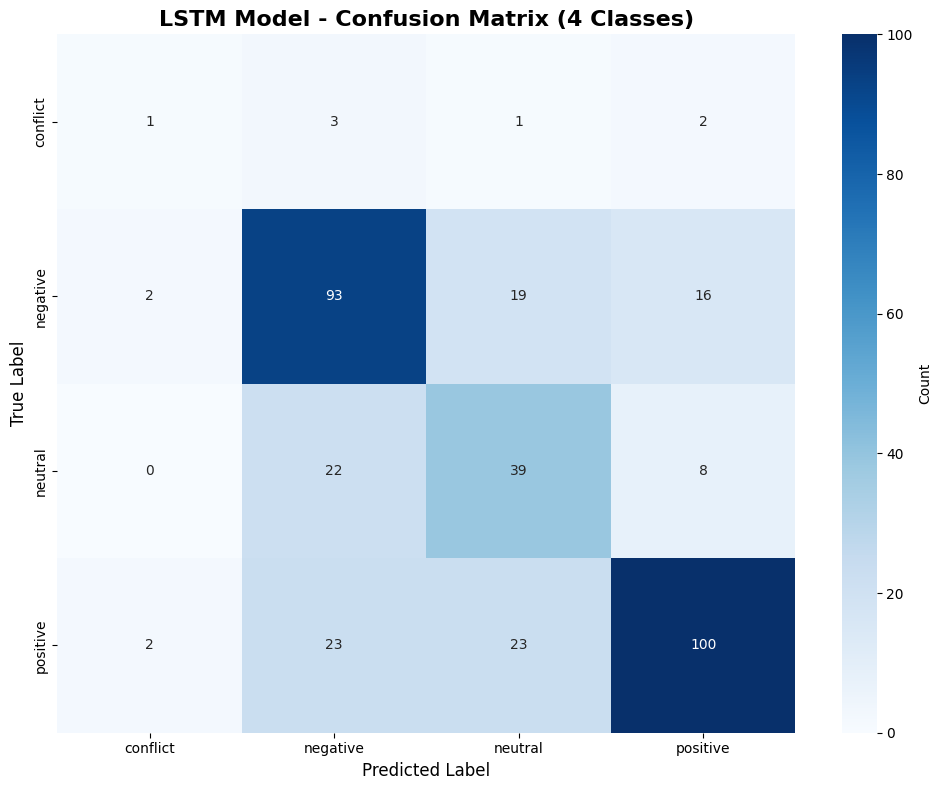

✓ Confusion matrix saved

[5/6] Creating per-class metrics visualization...


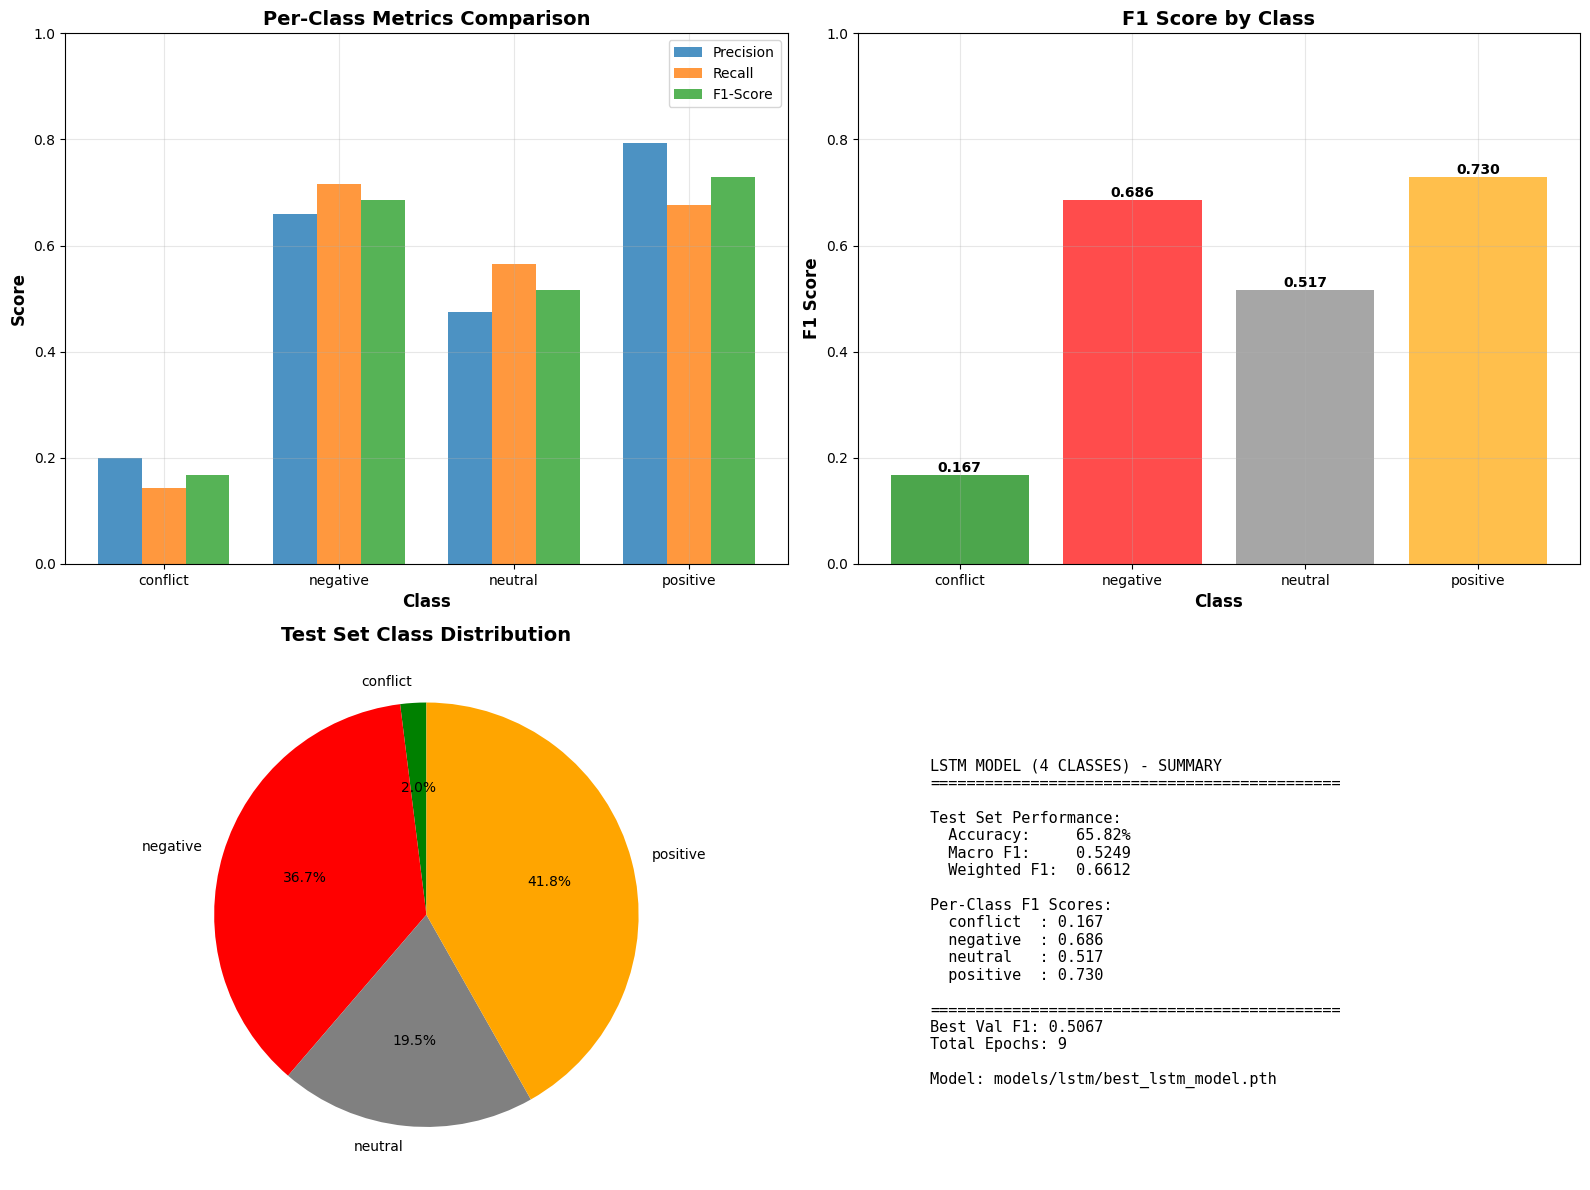

✓ Per-class metrics visualization saved

[6/6] Saving final results...
✓ Final results saved

EVALUATION COMPLETE!

📊 Files Created:
   1. models/lstm/best_lstm_model.pth
   2. results/figures/lstm/training_history.png
   3. results/figures/lstm/confusion_matrix.png
   4. results/figures/lstm/metrics_comparison.png
   5. results/reports/lstm_classification_report.txt
   6. results/reports/lstm_final_results.json
   7. results/reports/lstm_complete_results.pkl

🎯 Test Results (4 Classes):
   Accuracy:    65.82%
   Macro F1:    0.5249
   Weighted F1: 0.6612

📈 Per-Class F1 Scores:
   conflict  : 0.1667
   negative  : 0.6863
   neutral   : 0.5166
   positive  : 0.7299

✅ LSTM MODEL (4 CLASSES) COMPLETE!

💡 Next: Run Hybrid Model Section 5 for comparison!


In [6]:
"""
=====================================================================
LSTM MODEL (4 CLASSES) - SECTION 5: EVALUATION & VISUALIZATION
=====================================================================
"""

print("="*70)
print("SECTION 5: EVALUATION & VISUALIZATION (4 CLASSES)")
print("="*70)

# ============================================================================
# 1. LOAD BEST MODEL
# ============================================================================
print("\n[1/6] Loading best model...")

# Initialize model
best_model = LSTMClassifier(**model_config).to(device)

# Load checkpoint
checkpoint = torch.load('../models/lstm/best_lstm_model.pth', map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

print(f"✓ Best model loaded from epoch {checkpoint['epoch']}")
print(f"✓ Best validation F1: {checkpoint['best_val_f1']:.4f}")

# ============================================================================
# 2. EVALUATE ON TEST SET
# ============================================================================
print("\n[2/6] Evaluating on test set...")

test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        
        predictions = best_model(sequences)
        predicted_labels = predictions.argmax(1)
        
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_predictions = np.array(test_predictions)
test_true_labels = np.array(test_true_labels)

# Calculate metrics
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_f1_macro = f1_score(test_true_labels, test_predictions, average='macro')
test_f1_weighted = f1_score(test_true_labels, test_predictions, average='weighted')

print(f"\n✓ Test Evaluation Complete")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Macro F1: {test_f1_macro:.4f}")
print(f"  Weighted F1: {test_f1_weighted:.4f}")

# ============================================================================
# 3. CLASSIFICATION REPORT
# ============================================================================
print("\n[3/6] Generating classification report...")

# Get class names
class_names = list(label_encoder.classes_)

# Generate report
report_dict = classification_report(
    test_true_labels,
    test_predictions,
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

report_text = classification_report(
    test_true_labels,
    test_predictions,
    target_names=class_names,
    zero_division=0
)

print("\n" + "="*70)
print("CLASSIFICATION REPORT (4 CLASSES)")
print("="*70)
print(report_text)

# Save report
with open('../results/reports/lstm_classification_report.txt', 'w') as f:
    f.write("LSTM MODEL (4 CLASSES) - CLASSIFICATION REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(report_text)

print("✓ Classification report saved")

# ============================================================================
# 4. CONFUSION MATRIX
# ============================================================================
print("\n[4/6] Creating confusion matrix...")

cm = confusion_matrix(test_true_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('LSTM Model - Confusion Matrix (4 Classes)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('../results/figures/lstm/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

# ============================================================================
# 5. PER-CLASS METRICS VISUALIZATION
# ============================================================================
print("\n[5/6] Creating per-class metrics visualization...")

# Extract per-class metrics
metrics_data = {
    'Class': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Support': []
}

for class_name in class_names:
    metrics_data['Class'].append(class_name)
    metrics_data['Precision'].append(report_dict[class_name]['precision'])
    metrics_data['Recall'].append(report_dict[class_name]['recall'])
    metrics_data['F1-Score'].append(report_dict[class_name]['f1-score'])
    metrics_data['Support'].append(report_dict[class_name]['support'])

metrics_df = pd.DataFrame(metrics_data)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Per-class metrics comparison
ax1 = axes[0, 0]
x = np.arange(len(class_names))
width = 0.25

ax1.bar(x - width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax1.bar(x, metrics_df['Recall'], width, label='Recall', alpha=0.8)
ax1.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(class_names)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: F1-Score by class
ax2 = axes[0, 1]
colors = ['green', 'red', 'gray', 'orange']
bars = ax2.bar(class_names, metrics_df['F1-Score'], color=colors, alpha=0.7)
ax2.set_xlabel('Class', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('F1 Score by Class', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)

for bar, score in zip(bars, metrics_df['F1-Score']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.3f}',
            ha='center', va='bottom', fontweight='bold')

# Plot 3: Support distribution
ax3 = axes[1, 0]
ax3.pie(metrics_df['Support'], labels=class_names, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax3.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')

# Plot 4: Summary statistics
ax4 = axes[1, 1]
summary_text = f"""
LSTM MODEL (4 CLASSES) - SUMMARY
{'='*45}

Test Set Performance:
  Accuracy:     {test_accuracy*100:.2f}%
  Macro F1:     {test_f1_macro:.4f}
  Weighted F1:  {test_f1_weighted:.4f}

Per-Class F1 Scores:
"""

for _, row in metrics_df.iterrows():
    summary_text += f"  {row['Class']:10s}: {row['F1-Score']:.3f}\n"

summary_text += f"\n{'='*45}\n"
summary_text += f"Best Val F1: {checkpoint['best_val_f1']:.4f}\n"
summary_text += f"Total Epochs: {checkpoint['epoch']}\n"
summary_text += f"\nModel: models/lstm/best_lstm_model.pth"

ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center')
ax4.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/lstm/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Per-class metrics visualization saved")

# ============================================================================
# 6. SAVE FINAL RESULTS
# ============================================================================
print("\n[6/6] Saving final results...")

# Prepare final results
final_results = {
    'model_name': 'LSTM (4 Classes)',
    'num_classes': 4,
    'classes': class_names,
    'test_accuracy': float(test_accuracy),
    'test_macro_f1': float(test_f1_macro),
    'test_weighted_f1': float(test_f1_weighted),
    'per_class_f1': {
        class_name: float(report_dict[class_name]['f1-score'])
        for class_name in class_names
    },
    'per_class_metrics': {
        class_name: {
            'precision': float(report_dict[class_name]['precision']),
            'recall': float(report_dict[class_name]['recall']),
            'f1-score': float(report_dict[class_name]['f1-score']),
            'support': int(report_dict[class_name]['support'])
        }
        for class_name in class_names
    },
    'confusion_matrix': cm.tolist(),
    'best_val_f1': float(checkpoint['best_val_f1']),
    'total_epochs': int(checkpoint['epoch']),
    'model_path': 'models/lstm/best_lstm_model.pth'
}

# Save as JSON
with open('../results/reports/lstm_final_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

# Save complete results as pickle
complete_results = {
    'model_state_dict': best_model.state_dict(),
    'predictions': test_predictions,
    'true_labels': test_true_labels,
    'classification_report': report_dict,
    'confusion_matrix': cm,
    'final_results': final_results,
    'label_encoder': label_encoder,
    'vocab': vocab
}

with open('../results/reports/lstm_complete_results.pkl', 'wb') as f:
    pickle.dump(complete_results, f)

print("✓ Final results saved")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("EVALUATION COMPLETE!")
print("="*70)

print("\n📊 Files Created:")
print("   1. models/lstm/best_lstm_model.pth")
print("   2. results/figures/lstm/training_history.png")
print("   3. results/figures/lstm/confusion_matrix.png")
print("   4. results/figures/lstm/metrics_comparison.png")
print("   5. results/reports/lstm_classification_report.txt")
print("   6. results/reports/lstm_final_results.json")
print("   7. results/reports/lstm_complete_results.pkl")

print("\n🎯 Test Results (4 Classes):")
print(f"   Accuracy:    {test_accuracy*100:.2f}%")
print(f"   Macro F1:    {test_f1_macro:.4f}")
print(f"   Weighted F1: {test_f1_weighted:.4f}")

print("\n📈 Per-Class F1 Scores:")
for class_name in class_names:
    f1 = report_dict[class_name]['f1-score']
    print(f"   {class_name:10s}: {f1:.4f}")

print("\n" + "="*70)
print("✅ LSTM MODEL (4 CLASSES) COMPLETE!")
print("="*70)
print("\n💡 Next: Run Hybrid Model Section 5 for comparison!")

#   VERIFICATION STEPS

In [7]:
# Check if all files exist
import os

files_to_check = [
    '../models/lstm/best_lstm_model.pth',
    '../results/figures/lstm/eda_complete.png',
    '../results/figures/lstm/training_history.png',
    '../results/figures/lstm/confusion_matrix.png',
    '../results/figures/lstm/metrics_comparison.png',
    '../results/reports/lstm_final_results.json',
    '../results/reports/lstm_summary_report.txt',
    '../logs/lstm_training.log'
]

for file in files_to_check:
    if os.path.exists(file):
        print(f"✅ {file}")
    else:
        print(f"❌ {file} - MISSING!")

✅ ../models/lstm/best_lstm_model.pth
✅ ../results/figures/lstm/eda_complete.png
✅ ../results/figures/lstm/training_history.png
✅ ../results/figures/lstm/confusion_matrix.png
✅ ../results/figures/lstm/metrics_comparison.png
✅ ../results/reports/lstm_final_results.json
✅ ../results/reports/lstm_summary_report.txt
✅ ../logs/lstm_training.log


# GAT Model

Setup & Imports

In [8]:
"""
GAT-Based ABSA - Section 1: Setup & Imports
==============================================
Graph Attention Networks ke liye required libraries
"""

import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pickle
import json
import os

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# PyTorch Geometric (Graph Neural Networks)
try:
    import torch_geometric
    from torch_geometric.data import Data, Batch
    from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
    print(f"✅ PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    print("❌ PyTorch Geometric not installed!")
    print("Install using: pip install torch-geometric")

# NLP Libraries
import nltk
import spacy
from nltk.tokenize import word_tokenize

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')

# Load spaCy model for dependency parsing
try:
    nlp = spacy.load('en_core_web_sm')
    print("✅ spaCy model loaded successfully")
except:
    print("❌ spaCy model not found!")
    print("Install using: python -m spacy download en_core_web_sm")

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# Visualization
from tqdm import tqdm
import time

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create directories
os.makedirs('../models/gat', exist_ok=True)
os.makedirs('../results/figures/gat', exist_ok=True)
os.makedirs('../results/reports', exist_ok=True)
os.makedirs('../logs', exist_ok=True)

print("\n✅ All imports successful!")
print("=" * 60)

✅ PyTorch Geometric version: 2.7.0
✅ spaCy model loaded successfully

🖥️  Device: cpu

✅ All imports successful!


Data Loading & Graph Construction

✅ Training data loaded: (2358, 6)

Columns: ['id', 'Sentence', 'Aspect Term', 'polarity', 'from', 'to']

First few rows:
     id                                           Sentence     Aspect Term  \
0  2339  I charge it at night and skip taking the cord ...            cord   
1  2339  I charge it at night and skip taking the cord ...    battery life   
2  1316  The tech guy then said the service center does...  service center   
3  1316  The tech guy then said the service center does...    "sales" team   
4  1316  The tech guy then said the service center does...        tech guy   

   polarity  from   to  
0   neutral    41   45  
1  positive    74   86  
2  negative    27   41  
3  negative   109  121  
4   neutral     4   12  

📊 DATA STATISTICS

1. Total Training Samples: 2358
2. Unique Sentences: 1482
3. Unique Aspects: 1042

4. Sentiment Distribution:
polarity
positive    987
negative    866
neutral     460
conflict     45
Name: count, dtype: int64

Percentages:
polarity
positive

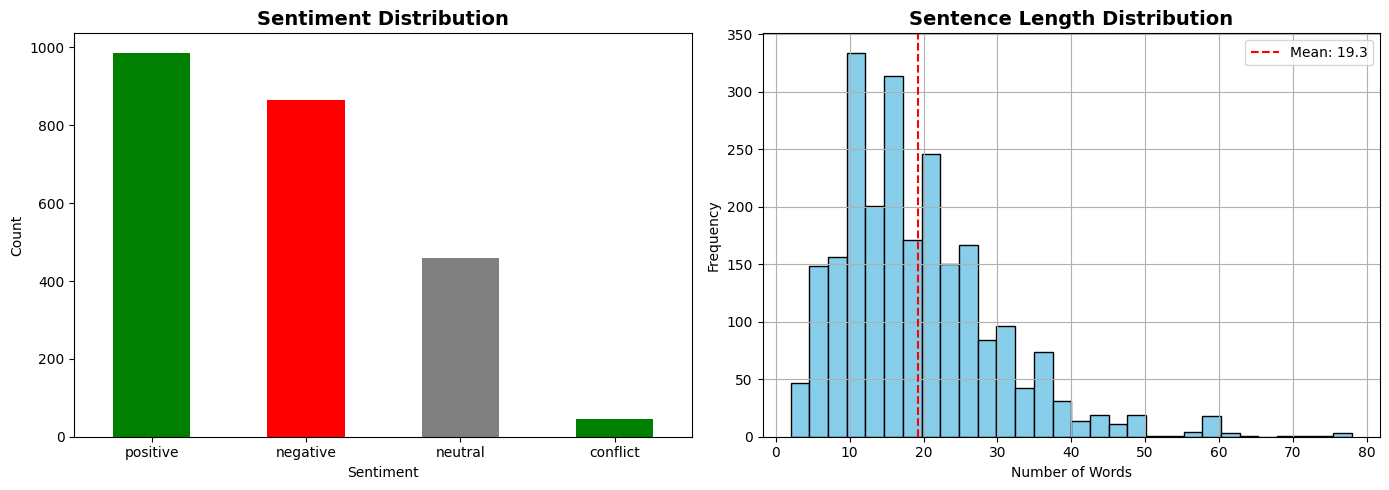


5. Sentence Length Stats:
   Mean: 19.32
   Median: 17.00
   Max: 78

6. Top 10 Most Frequent Aspects:
Aspect Term
screen          58
price           55
use             53
battery life    52
battery         45
keyboard        43
programs        36
software        33
features        32
warranty        31
Name: count, dtype: int64

🔧 GRAPH CONSTRUCTION LOGIC

📝 Example Graph Construction:

Sentence: I charge it at night and skip taking the cord with me because of the good battery life.
Aspect: cord
Sentiment: neutral

✅ Graph Info:
   Nodes: 19
   Edges: 55
   Nodes: ['i', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord', 'with', 'me', 'because', 'of', 'the', 'good', 'battery', 'life', '.']
   Aspect Mask: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Sample Edges: [(0, 0), (1, 0), (0, 1), (1, 1), (2, 2), (1, 2), (2, 1), (3, 3), (1, 3), (3, 1)]
   Sample Edge Types: ['self', 'nsubj', 'nsubj_rev', 'self', 'self', 'dobj', 'dobj_rev', 'self', 'prep', 'pr

100%|██████████| 2358/2358 [00:12<00:00, 185.18it/s]



✅ Successfully created 2358 graphs!
✅ Graphs saved to: ../data/processed/gat_graphs.pkl

📊 Graph Statistics:
Average Nodes per Graph: 22.23
Average Edges per Graph: 64.61
Max Nodes: 84
Max Edges: 250

✅ Section 2 Complete!


In [9]:
"""
GAT-Based ABSA - Section 2: Data Loading & Graph Construction
==============================================================
Load data aur dependency-based graphs banao
"""

# Load training data
train_df = pd.read_csv('../data/raw/Laptop_Train_v2.csv')
print(f"✅ Training data loaded: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())

# Data Statistics
print("\n" + "="*60)
print("📊 DATA STATISTICS")
print("="*60)

print(f"\n1. Total Training Samples: {len(train_df)}")
print(f"2. Unique Sentences: {train_df['Sentence'].nunique()}")
print(f"3. Unique Aspects: {train_df['Aspect Term'].nunique()}")

print("\n4. Sentiment Distribution:")
sentiment_dist = train_df['polarity'].value_counts()
print(sentiment_dist)
print(f"\nPercentages:")
print((sentiment_dist / len(train_df) * 100).round(2))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentiment Distribution
sentiment_dist.plot(kind='bar', ax=axes[0], color=['green', 'red', 'gray'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Sentence Length Distribution
train_df['sent_length'] = train_df['Sentence'].apply(lambda x: len(x.split()))
train_df['sent_length'].hist(bins=30, ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Sentence Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(train_df['sent_length'].mean(), color='red', linestyle='--', 
                label=f"Mean: {train_df['sent_length'].mean():.1f}")
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/figures/gat/data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n5. Sentence Length Stats:")
print(f"   Mean: {train_df['sent_length'].mean():.2f}")
print(f"   Median: {train_df['sent_length'].median():.2f}")
print(f"   Max: {train_df['sent_length'].max()}")

# Top Aspects
print("\n6. Top 10 Most Frequent Aspects:")
top_aspects = train_df['Aspect Term'].value_counts().head(10)
print(top_aspects)

print("\n" + "="*60)
print("🔧 GRAPH CONSTRUCTION LOGIC")
print("="*60)

def build_dependency_graph(sentence, aspect_term, aspect_start, aspect_end):
    """
    Dependency parsing karke graph banao
    
    Returns:
        - nodes: List of words
        - edges: List of (source, target) tuples
        - edge_types: List of dependency relations
        - aspect_mask: Binary mask for aspect words
    """
    # Parse sentence with spaCy
    doc = nlp(sentence.lower())
    
    # Nodes (words)
    nodes = [token.text for token in doc]
    node_pos = [token.pos_ for token in doc]  # POS tags
    
    # Edges (dependencies)
    edges = []
    edge_types = []
    
    for token in doc:
        # Self-loop for each node
        edges.append((token.i, token.i))
        edge_types.append('self')
        
        # Dependencies
        if token.head != token:  # Not root
            # Parent to child
            edges.append((token.head.i, token.i))
            edge_types.append(token.dep_)
            
            # Child to parent (bidirectional)
            edges.append((token.i, token.head.i))
            edge_types.append(token.dep_ + '_rev')
    
    # Aspect mask
    aspect_mask = [0] * len(nodes)
    aspect_tokens = aspect_term.lower().split()
    
    # Mark aspect words
    for i, token in enumerate(doc):
        if token.text in aspect_tokens:
            aspect_mask[i] = 1
    
    return nodes, edges, edge_types, aspect_mask, node_pos

# Test graph construction
print("\n📝 Example Graph Construction:")
sample_row = train_df.iloc[0]
print(f"\nSentence: {sample_row['Sentence']}")
print(f"Aspect: {sample_row['Aspect Term']}")
print(f"Sentiment: {sample_row['polarity']}")

nodes, edges, edge_types, aspect_mask, node_pos = build_dependency_graph(
    sample_row['Sentence'],
    sample_row['Aspect Term'],
    sample_row['from'],
    sample_row['to']
)

print(f"\n✅ Graph Info:")
print(f"   Nodes: {len(nodes)}")
print(f"   Edges: {len(edges)}")
print(f"   Nodes: {nodes}")
print(f"   Aspect Mask: {aspect_mask}")
print(f"   Sample Edges: {edges[:10]}")
print(f"   Sample Edge Types: {edge_types[:10]}")

# Visualize dependency tree
print("\n🌳 Dependency Tree:")
doc = nlp(sample_row['Sentence'])
for token in doc[:10]:  # First 10 tokens
    print(f"{token.text:15} -> {token.dep_:10} -> {token.head.text}")

print("\n" + "="*60)
print("📦 PROCESSING ALL DATA")
print("="*60)

# Process all training samples
all_graphs = []
all_labels = []

print("\nBuilding graphs for all sentences...")
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        nodes, edges, edge_types, aspect_mask, node_pos = build_dependency_graph(
            row['Sentence'],
            row['Aspect Term'],
            row['from'],
            row['to']
        )
        
        all_graphs.append({
            'sentence': row['Sentence'],
            'aspect_term': row['Aspect Term'],
            'nodes': nodes,
            'edges': edges,
            'edge_types': edge_types,
            'aspect_mask': aspect_mask,
            'node_pos': node_pos,
            'sentiment': row['polarity']
        })
        all_labels.append(row['polarity'])
        
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        continue

print(f"\n✅ Successfully created {len(all_graphs)} graphs!")

# Save processed graphs
with open('../data/processed/gat_graphs.pkl', 'wb') as f:
    pickle.dump(all_graphs, f)
print("✅ Graphs saved to: ../data/processed/gat_graphs.pkl")

# Graph Statistics
print("\n📊 Graph Statistics:")
num_nodes = [len(g['nodes']) for g in all_graphs]
num_edges = [len(g['edges']) for g in all_graphs]

print(f"Average Nodes per Graph: {np.mean(num_nodes):.2f}")
print(f"Average Edges per Graph: {np.mean(num_edges):.2f}")
print(f"Max Nodes: {np.max(num_nodes)}")
print(f"Max Edges: {np.max(num_edges)}")

print("\n✅ Section 2 Complete!")
print("="*60)

Vocabulary & Dataset

In [10]:
"""
GAT-Based ABSA - Section 3: Vocabulary Building & Dataset Preparation
======================================================================
Vocabulary banao aur PyTorch Geometric dataset prepare karo
"""

print("="*60)
print("📚 VOCABULARY BUILDING")
print("="*60)

# Build vocabulary from all nodes
all_words = []
all_pos_tags = []
all_edge_types = set()

for graph in all_graphs:
    all_words.extend(graph['nodes'])
    all_pos_tags.extend(graph['node_pos'])
    all_edge_types.update(graph['edge_types'])

# Word vocabulary
word_counter = Counter(all_words)
print(f"\nTotal unique words: {len(word_counter)}")
print(f"Total word occurrences: {sum(word_counter.values())}")

# Create word-to-index mapping
word2idx = {'<PAD>': 0, '<UNK>': 1}
for word, count in word_counter.most_common():
    if count >= 2:  # Minimum frequency threshold
        word2idx[word] = len(word2idx)

idx2word = {v: k for k, v in word2idx.items()}
vocab_size = len(word2idx)

print(f"Vocabulary size (freq >= 2): {vocab_size}")
print(f"\nTop 20 words:")
for word, count in word_counter.most_common(20):
    print(f"  {word:15} : {count:4d}")

# POS tag vocabulary
pos2idx = {pos: i for i, pos in enumerate(set(all_pos_tags))}
idx2pos = {v: k for k, v in pos2idx.items()}
print(f"\nPOS Tags: {len(pos2idx)}")
print(f"POS tags: {list(pos2idx.keys())}")

# Edge type vocabulary
edge2idx = {edge: i for i, edge in enumerate(all_edge_types)}
idx2edge = {v: k for k, v in edge2idx.items()}
print(f"\nEdge Types: {len(edge2idx)}")

# Label encoding
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)
print(f"\nSentiment Labels: {label_encoder.classes_}")
print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Save vocabularies
vocab_data = {
    'word2idx': word2idx,
    'idx2word': idx2word,
    'pos2idx': pos2idx,
    'idx2pos': idx2pos,
    'edge2idx': edge2idx,
    'idx2edge': idx2edge,
    'label_encoder': label_encoder
}

with open('../data/processed/gat_vocab.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)
print("\n✅ Vocabulary saved!")

print("\n" + "="*60)
print("🔨 DATASET PREPARATION")
print("="*60)

class ABSAGraphDataset(Dataset):
    """
    PyTorch Geometric dataset for ABSA
    """
    def __init__(self, graphs, word2idx, pos2idx, label_encoder):
        self.graphs = graphs
        self.word2idx = word2idx
        self.pos2idx = pos2idx
        self.label_encoder = label_encoder
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        graph = self.graphs[idx]
        
        # Convert words to indices
        node_features = []
        for i, (word, pos) in enumerate(zip(graph['nodes'], graph['node_pos'])):
            word_idx = self.word2idx.get(word, self.word2idx['<UNK>'])
            pos_idx = self.pos2idx.get(pos, 0)
            is_aspect = graph['aspect_mask'][i]
            
            # Node feature: [word_idx, pos_idx, is_aspect]
            node_features.append([word_idx, pos_idx, is_aspect])
        
        node_features = torch.tensor(node_features, dtype=torch.float)
        
        # Edge indices
        edge_index = torch.tensor(graph['edges'], dtype=torch.long).t().contiguous()
        
        # Label
        label = self.label_encoder.transform([graph['sentiment']])[0]
        label = torch.tensor(label, dtype=torch.long)
        
        # Create PyG Data object
        data = Data(
            x=node_features,
            edge_index=edge_index,
            y=label,
            num_nodes=len(graph['nodes'])
        )
        
        return data

print("\n📦 Creating datasets...")

# Train-Validation Split
train_graphs, val_graphs, train_labels, val_labels = train_test_split(
    all_graphs, all_labels_encoded, 
    test_size=0.15, 
    random_state=SEED,
    stratify=all_labels_encoded
)

print(f"Training samples: {len(train_graphs)}")
print(f"Validation samples: {len(val_graphs)}")

# Create datasets
train_dataset = ABSAGraphDataset(train_graphs, word2idx, pos2idx, label_encoder)
val_dataset = ABSAGraphDataset(val_graphs, word2idx, pos2idx, label_encoder)

print(f"\n✅ Datasets created!")
print(f"   Train: {len(train_dataset)}")
print(f"   Val: {len(val_dataset)}")

# Test dataset loading
print("\n🧪 Testing dataset:")
sample_data = train_dataset[0]
print(f"Sample graph:")
print(f"  Node features shape: {sample_data.x.shape}")
print(f"  Edge index shape: {sample_data.edge_index.shape}")
print(f"  Label: {sample_data.y}")
print(f"  Num nodes: {sample_data.num_nodes}")

# Create DataLoaders
from torch_geometric.loader import DataLoader as PyGDataLoader

BATCH_SIZE = 16

train_loader = PyGDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Test batch loading
print("\n🧪 Testing batch:")
for batch in train_loader:
    print(f"Batch:")
    print(f"  Nodes: {batch.x.shape}")
    print(f"  Edges: {batch.edge_index.shape}")
    print(f"  Labels: {batch.y.shape}")
    print(f"  Batch vector: {batch.batch.shape}")
    break

print("\n✅ Section 3 Complete!")
print("="*60)

📚 VOCABULARY BUILDING

Total unique words: 3161
Total word occurrences: 52423
Vocabulary size (freq >= 2): 2341

Top 20 words:
  the             : 2811
  ,               : 2204
  .               : 2175
  and             : 1611
  i               : 1246
  to              : 1232
  it              : 1134
  a               : 1033
  is              :  927
  of              :  677
  for             :  653
  that            :  496
  with            :  488
  my              :  402
  in              :  365
  you             :  355
  this            :  336
  was             :  318
  )               :  317
  (               :  316

POS Tags: 18
POS tags: ['VERB', 'ADP', 'ADJ', 'INTJ', 'SPACE', 'PROPN', 'PRON', 'ADV', 'PUNCT', 'CCONJ', 'SCONJ', 'PART', 'AUX', 'NUM', 'SYM', 'X', 'NOUN', 'DET']

Edge Types: 87

Sentiment Labels: ['conflict' 'negative' 'neutral' 'positive']
Label mapping: {np.str_('conflict'): 0, np.str_('negative'): 1, np.str_('neutral'): 2, np.str_('positive'): 3}

✅ Vocabulary save

Model Architecture & Training

In [11]:
"""
GAT-Based ABSA - Section 4: Model Architecture & Training
==========================================================
Graph Attention Network implementation aur training
"""

print("="*60)
print("🧠 GAT MODEL ARCHITECTURE")
print("="*60)

class GATForABSA(nn.Module):
    """
    Graph Attention Network for Aspect-Based Sentiment Analysis
    
    Architecture:
    1. Node Feature Embedding (word + POS + aspect indicator)
    2. Multi-head GAT Layers (2 layers)
    3. Graph-level Pooling (mean + max)
    4. Classification Head
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, 
                 num_heads=4, dropout=0.4):
        super(GATForABSA, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        
        # Embedding layers
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(20, 16)  # POS tags
        
        # Input dimension: word_emb + pos_emb + aspect_indicator
        input_dim = embedding_dim + 16 + 1
        
        # GAT Layers (Multi-head attention)
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout)
        
        # Pooling and classification
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # mean + max pooling
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim * num_heads)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Extract features
        word_idx = x[:, 0].long()
        pos_idx = x[:, 1].long()
        aspect_indicator = x[:, 2].unsqueeze(1)
        
        # Embeddings
        word_emb = self.word_embedding(word_idx)
        pos_emb = self.pos_embedding(pos_idx)
        
        # Concatenate features
        x = torch.cat([word_emb, pos_emb, aspect_indicator], dim=1)
        
        # GAT Layer 1
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        
        # GAT Layer 2
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.bn2(x)
        x = self.dropout(x)
        
        # Graph-level pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        
        # Classification head
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Model hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
NUM_HEADS = 4
DROPOUT = 0.4
NUM_CLASSES = len(label_encoder.classes_)

# Initialize model
model = GATForABSA(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
).to(device)

print(f"\n✅ Model created!")
print(f"\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\n" + "="*60)
print("🎯 TRAINING CONFIGURATION")
print("="*60)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Training parameters
NUM_EPOCHS = 25
PATIENCE = 7

print(f"Optimizer: Adam")
print(f"Learning Rate: 0.001")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Early Stopping Patience: {PATIENCE}")

# Training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(loader, desc="Training", leave=False):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch.y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch.y.size(0)
        correct += predicted.eq(batch.y).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch.y)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch.y.size(0)
            correct += predicted.eq(batch.y).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(loader), 100. * correct / total, f1

print("\n" + "="*60)
print("🚀 TRAINING START")
print("="*60)

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0
patience_counter = 0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc
        }, '../models/gat/best_gat_model.pth')
        print(f"✅ Best model saved! F1: {val_f1:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
        break

training_time = time.time() - start_time
print(f"\n⏱️  Total training time: {training_time/60:.2f} minutes")
print(f"🏆 Best Validation F1: {best_val_f1:.4f}")

# Save training history
with open('../results/reports/gat_training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("\n✅ Section 4 Complete!")
print("="*60)

🧠 GAT MODEL ARCHITECTURE

✅ Model created!

Model Architecture:
GATForABSA(
  (word_embedding): Embedding(2341, 128, padding_idx=0)
  (pos_embedding): Embedding(20, 16)
  (gat1): GATConv(145, 128, heads=4)
  (gat2): GATConv(512, 128, heads=1)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Total parameters: 476,356
Trainable parameters: 476,356

🎯 TRAINING CONFIGURATION
Optimizer: Adam
Learning Rate: 0.001
Batch Size: 16
Epochs: 25
Early Stopping Patience: 7

🚀 TRAINING START

Epoch 1/25
----------------------------------------


Train Loss: 1.1413 | Train Acc: 48.55%
Val Loss: 1.0890 | Val Acc: 55.37% | Val F1: 0.3087
✅ Best model saved! F1: 0.3087

Epoch 2/25
----------------------------------------


Train Loss: 1.0246 | Train Acc: 54.99%
Val Loss: 1.0239 | Val Acc: 56.78% | Val F1: 0.3238
✅ Best model saved! F1: 0.3238

Epoch 3/25
----------------------------------------


Train Loss: 0.9717 | Train Acc: 58.43%
Val Loss: 1.0063 | Val Acc: 57.91% | Val F1: 0.3353
✅ Best model saved! F1: 0.3353

Epoch 4/25
----------------------------------------


Train Loss: 0.9156 | Train Acc: 62.72%
Val Loss: 0.9731 | Val Acc: 60.73% | Val F1: 0.3458
✅ Best model saved! F1: 0.3458

Epoch 5/25
----------------------------------------


Train Loss: 0.8514 | Train Acc: 65.22%
Val Loss: 0.9431 | Val Acc: 60.73% | Val F1: 0.4045
✅ Best model saved! F1: 0.4045

Epoch 6/25
----------------------------------------


Train Loss: 0.8516 | Train Acc: 64.52%
Val Loss: 1.0354 | Val Acc: 59.32% | Val F1: 0.3739

Epoch 7/25
----------------------------------------


Train Loss: 0.8066 | Train Acc: 67.56%
Val Loss: 0.9569 | Val Acc: 61.86% | Val F1: 0.4081
✅ Best model saved! F1: 0.4081

Epoch 8/25
----------------------------------------


Train Loss: 0.7797 | Train Acc: 69.71%
Val Loss: 0.9284 | Val Acc: 63.56% | Val F1: 0.4440
✅ Best model saved! F1: 0.4440

Epoch 9/25
----------------------------------------


Train Loss: 0.7659 | Train Acc: 70.61%
Val Loss: 0.9456 | Val Acc: 63.56% | Val F1: 0.4364

Epoch 10/25
----------------------------------------


Train Loss: 0.7180 | Train Acc: 71.76%
Val Loss: 0.9120 | Val Acc: 65.25% | Val F1: 0.4595
✅ Best model saved! F1: 0.4595

Epoch 11/25
----------------------------------------


Train Loss: 0.6919 | Train Acc: 72.65%
Val Loss: 0.9193 | Val Acc: 66.95% | Val F1: 0.4796
✅ Best model saved! F1: 0.4796

Epoch 12/25
----------------------------------------


Train Loss: 0.6805 | Train Acc: 73.10%
Val Loss: 0.9434 | Val Acc: 66.95% | Val F1: 0.4767

Epoch 13/25
----------------------------------------


Train Loss: 0.6676 | Train Acc: 73.50%
Val Loss: 0.8963 | Val Acc: 68.08% | Val F1: 0.4847
✅ Best model saved! F1: 0.4847

Epoch 14/25
----------------------------------------


Train Loss: 0.6134 | Train Acc: 75.90%
Val Loss: 0.9251 | Val Acc: 67.80% | Val F1: 0.4844

Epoch 15/25
----------------------------------------


Train Loss: 0.6278 | Train Acc: 75.55%
Val Loss: 0.9868 | Val Acc: 69.21% | Val F1: 0.5011
✅ Best model saved! F1: 0.5011

Epoch 16/25
----------------------------------------


Train Loss: 0.5851 | Train Acc: 78.59%
Val Loss: 0.9944 | Val Acc: 67.51% | Val F1: 0.4855

Epoch 17/25
----------------------------------------


Train Loss: 0.5572 | Train Acc: 78.39%
Val Loss: 1.0054 | Val Acc: 65.82% | Val F1: 0.4760

Epoch 18/25
----------------------------------------


Train Loss: 0.5120 | Train Acc: 80.59%
Val Loss: 0.9782 | Val Acc: 70.06% | Val F1: 0.5041
✅ Best model saved! F1: 0.5041

Epoch 19/25
----------------------------------------


Train Loss: 0.5246 | Train Acc: 79.49%
Val Loss: 0.9994 | Val Acc: 68.36% | Val F1: 0.4971

Epoch 20/25
----------------------------------------


Train Loss: 0.5178 | Train Acc: 80.04%
Val Loss: 1.0592 | Val Acc: 67.51% | Val F1: 0.4876

Epoch 21/25
----------------------------------------


Train Loss: 0.4872 | Train Acc: 81.19%
Val Loss: 1.0917 | Val Acc: 64.41% | Val F1: 0.4662

Epoch 22/25
----------------------------------------


Train Loss: 0.4830 | Train Acc: 81.79%
Val Loss: 1.0985 | Val Acc: 66.95% | Val F1: 0.4847

Epoch 23/25
----------------------------------------


Train Loss: 0.4479 | Train Acc: 82.14%
Val Loss: 1.1151 | Val Acc: 68.08% | Val F1: 0.4931

Epoch 24/25
----------------------------------------


Train Loss: 0.4794 | Train Acc: 80.94%
Val Loss: 1.1266 | Val Acc: 67.51% | Val F1: 0.4865

Epoch 25/25
----------------------------------------


Train Loss: 0.4410 | Train Acc: 82.98%
Val Loss: 1.1171 | Val Acc: 68.64% | Val F1: 0.4969

⚠️  Early stopping triggered after 25 epochs

⏱️  Total training time: 1.27 minutes
🏆 Best Validation F1: 0.5041

✅ Section 4 Complete!


 Evaluation & Visualization

📊 MODEL EVALUATION
✅ Best model loaded!
   Epoch: 17
   Val Accuracy: 70.06%
   Val F1: 0.5041

🔍 Validation Set Evaluation:


Evaluating: 100%|██████████| 23/23 [00:00<00:00, 91.83it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

    conflict     0.0000    0.0000    0.0000         7
    negative     0.7500    0.7385    0.7442       130
     neutral     0.6038    0.4638    0.5246        69
    positive     0.6936    0.8108    0.7477       148

    accuracy                         0.7006       354
   macro avg     0.5119    0.5033    0.5041       354
weighted avg     0.6831    0.7006    0.6881       354


Confusion Matrix:
[[  0   2   1   4]
 [  0  96   6  28]
 [  0  16  32  21]
 [  0  14  14 120]]

Per-Class Metrics:
conflict   - Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | Support: 7
negative   - Precision: 0.7500 | Recall: 0.7385 | F1: 0.7442 | Support: 130
neutral    - Precision: 0.6038 | Recall: 0.4638 | F1: 0.5246 | Support: 69
positive   - Precision: 0.6936 | Recall: 0.8108 | F1: 0.7477 | Support: 148

📊 VISUALIZATIONS


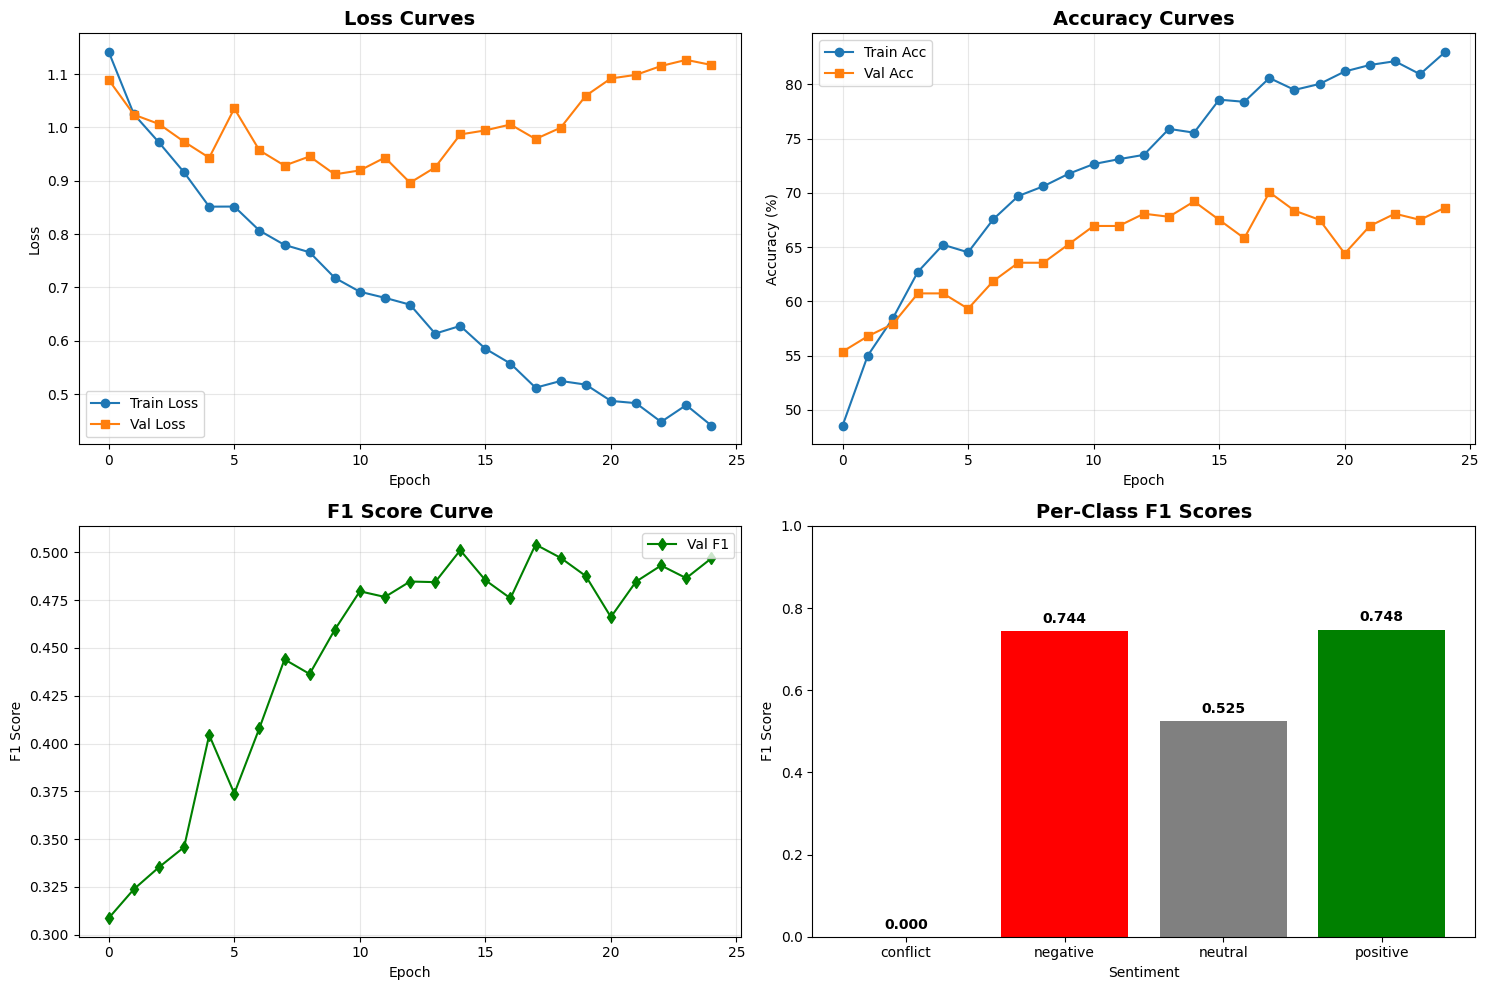

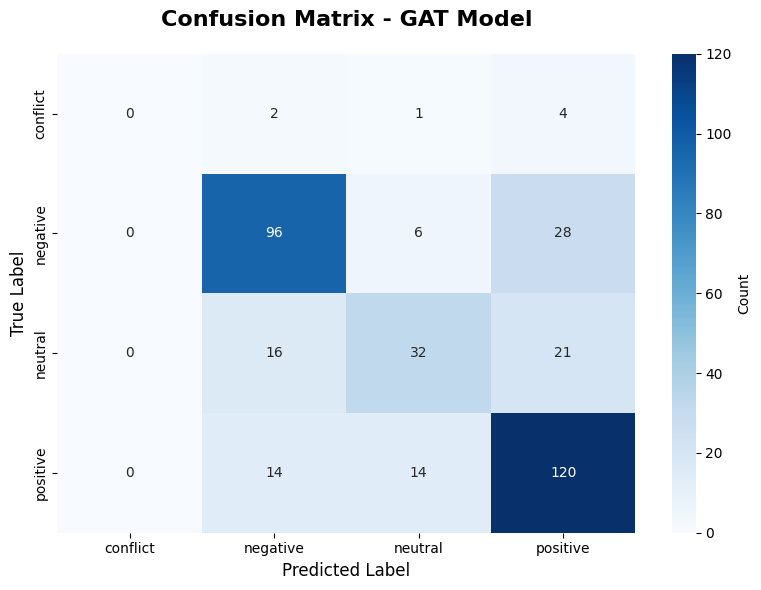

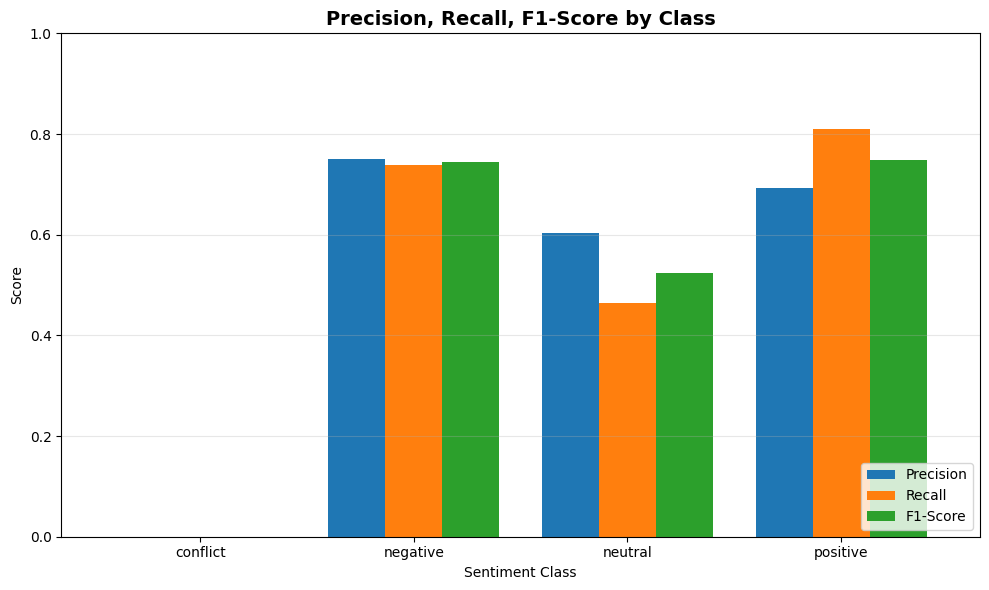


✅ Visualizations saved!

🎯 SAMPLE PREDICTIONS (GAT MODEL)

📝 Sample Predictions:
------------------------------------------------------------

Sample 1:
Sentence: Summary: They played games with me for the warranty period....
Aspect: warranty period
Predicted: neutral | Actual: negative
❌ Wrong

Sample 2:
Sentence: It is so nice not to worry about that and the extra expense that comes along wit...
Aspect: virus protection
Predicted: positive | Actual: positive
✅ Correct

Sample 3:
Sentence: Later it held zero charge and its replacement worked for less than three months....
Aspect: charge
Predicted: negative | Actual: negative
✅ Correct

Sample 4:
Sentence: The reflectiveness of the display is only a minor inconvenience if you work in a...
Aspect: display
Predicted: neutral | Actual: negative
❌ Wrong

Sample 5:
Sentence: Even doing so, the hinge may just be slightly tightened only....
Aspect: hinge
Predicted: negative | Actual: neutral
❌ Wrong

💾 FINAL RESULTS SUMMARY

📊 Final Metrics:

In [12]:
"""
GAT-Based ABSA - Section 5: Evaluation & Visualization
=======================================================
Model evaluation aur results visualization
"""

print("="*60)
print("📊 MODEL EVALUATION")
print("="*60)

# Load best model
checkpoint = torch.load('../models/gat/best_gat_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Best model loaded!")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Val Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"   Val F1: {checkpoint['val_f1']:.4f}")

# Detailed evaluation
def detailed_evaluation(model, loader, label_encoder, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            batch = batch.to(device)
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("\n🔍 Validation Set Evaluation:")
val_preds, val_labels, val_probs = detailed_evaluation(model, val_loader, label_encoder, device)

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    val_labels, val_preds, 
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
print("\nConfusion Matrix:")
print(cm)

# Per-class metrics
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(
    val_labels, val_preds, average=None
)

print("\nPer-Class Metrics:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label:10} - Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f} | Support: {support[i]}")

print("\n" + "="*60)
print("📊 VISUALIZATIONS")
print("="*60)

# 1. Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_title('Loss Curves', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_title('Accuracy Curves', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score curve
axes[1, 0].plot(history['val_f1'], label='Val F1', marker='d', color='green')
axes[1, 0].set_title('F1 Score Curve', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Per-class F1 scores
axes[1, 1].bar(label_encoder.classes_, f1, color=['green', 'red', 'gray'])
axes[1, 1].set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(f1):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/gat/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - GAT Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('../results/figures/gat/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Precision-Recall-F1 Comparison
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=label_encoder.classes_)

metrics_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Precision, Recall, F1-Score by Class', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../results/figures/gat/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations saved!")

# print("\n" + "="*60)
# print("🎯 ATTENTION VISUALIZATION")
# print("="*60)

# def visualize_attention(model, graph_data, sentence, aspect):
#     """
#     GAT attention weights visualization
#     """
#     model.eval()
    
#     with torch.no_grad():
#         # Get attention weights from first GAT layer
#         x, edge_index = graph_data.x.to(device), graph_data.edge_index.to(device)
        
#         # Extract features
#         word_idx = x[:, 0].long()
#         pos_idx = x[:, 1].long()
#         aspect_indicator = x[:, 2].unsqueeze(1)
        
#         word_emb = model.word_embedding(word_idx)
#         pos_emb = model.pos_embedding(pos_idx)
#         x = torch.cat([word_emb, pos_emb, aspect_indicator], dim=1)
        
#         # Forward through GAT (with attention return)
#         # Note: PyG's GATConv doesn't return attention by default
#         # This is a simplified visualization
#         output = model(graph_data.unsqueeze(0).to(device))
#         pred = output.argmax(dim=1).item()
    
#     return label_encoder.classes_[pred]

# # Sample predictions
# print("\n📝 Sample Predictions:")
# print("-" * 60)

# for i in range(5):
#     sample = val_dataset[i]
#     graph_data = all_graphs[val_graphs[i] == all_graphs][0]
    
#     prediction = visualize_attention(model, sample, 
#                                     graph_data['sentence'], 
#                                     graph_data['aspect_term'])
#     actual = label_encoder.classes_[sample.y.item()]
    
#     print(f"\nSample {i+1}:")
#     print(f"Sentence: {graph_data['sentence'][:80]}...")
#     print(f"Aspect: {graph_data['aspect_term']}")
#     print(f"Predicted: {prediction} | Actual: {actual}")
#     print(f"✅ Correct" if prediction == actual else "❌ Wrong") 

print("\n" + "="*60)
print("🎯 SAMPLE PREDICTIONS (GAT MODEL)")
print("="*60)

from torch_geometric.data import Batch

def predict_sentiment_single(model, graph_data, label_encoder, device):
    """
    Single graph ke liye sentiment prediction helper
    """
    model.eval()
    with torch.no_grad():
        # Graph ko device par bhejo
        graph_data = graph_data.to(device)
        
        # Single graph ko Batch bana kar model me pass karo
        batch_data = Batch.from_data_list([graph_data])
        outputs = model(batch_data)
        pred_idx = outputs.argmax(dim=1).item()
        
    return label_encoder.classes_[pred_idx]

print("\n📝 Sample Predictions:")
print("-" * 60)

num_samples = min(5, len(val_dataset))  # agar val me 5 se kam samples ho to bhi safe

for i in range(num_samples):
    # PyG Data object
    pyg_data = val_dataset[i]
    
    # Graph ka original info (sentence, aspect) yahi se aayega
    graph_info = val_graphs[i]   # ❗ yaha koi boolean indexing nahi, sirf direct index
    
    prediction = predict_sentiment_single(model, pyg_data, label_encoder, device)
    actual = label_encoder.classes_[pyg_data.y.item()]
    
    print(f"\nSample {i+1}:")
    print(f"Sentence: {graph_info['sentence'][:80]}...")
    print(f"Aspect: {graph_info['aspect_term']}")
    print(f"Predicted: {prediction} | Actual: {actual}")
    print("✅ Correct" if prediction == actual else "❌ Wrong")


print("\n" + "="*60)
print("💾 FINAL RESULTS SUMMARY")
print("="*60)

# Save final results
results_summary = {
    'model': 'GAT',
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_heads': NUM_HEADS,
    'dropout': DROPOUT,
    'num_epochs_trained': len(history['train_loss']),
    'best_epoch': checkpoint['epoch'],
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'val_accuracy': checkpoint['val_acc'],
    'val_f1_macro': checkpoint['val_f1'],
    'per_class_f1': dict(zip(label_encoder.classes_, f1)),
    'per_class_precision': dict(zip(label_encoder.classes_, precision)),
    'per_class_recall': dict(zip(label_encoder.classes_, recall)),
    'confusion_matrix': cm.tolist(),
    'training_time_minutes': training_time / 60
}

with open('../results/reports/gat_final_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\n📊 Final Metrics:")
print(f"   Validation Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"   Validation F1 (Macro): {checkpoint['val_f1']:.4f}")
print(f"   Training Time: {training_time/60:.2f} minutes")

print("\nPer-Class F1 Scores:")
for label, score in zip(label_encoder.classes_, f1):
    print(f"   {label:10}: {score:.4f}")

print("\n✅ Results saved to:")
print("   - ../models/gat/best_gat_model.pth")
print("   - ../results/figures/gat/")
print("   - ../results/reports/gat_final_results.json")

print("\n" + "="*60)
print("🎉 GAT MODEL TRAINING COMPLETE!")
print("="*60)
print("\n✅ Section 5 Complete!")

# Hybrid Model (LSTM + GAT

Setup & Imports

In [13]:
"""
Hybrid Model (LSTM + GAT) - Section 1: Setup & Imports
=======================================================
LSTM aur GAT dono models ko combine karenge
"""

import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pickle
import json
import os

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# PyTorch Geometric (for GAT)
try:
    import torch_geometric
    from torch_geometric.data import Data, Batch
    from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
    print(f"✅ PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    print("❌ PyTorch Geometric not installed!")

# NLP Libraries
import nltk
import spacy
from nltk.tokenize import word_tokenize

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# Visualization
from tqdm import tqdm
import time

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Load spaCy
try:
    nlp = spacy.load('en_core_web_sm')
    print("✅ spaCy model loaded")
except:
    print("❌ spaCy model not found!")

# Create directories
os.makedirs('../models/hybrid', exist_ok=True)
os.makedirs('../results/figures/hybrid', exist_ok=True)
os.makedirs('../results/figures/comparison', exist_ok=True)

print("\n✅ All imports successful!")
print("=" * 60)
print("🔥 HYBRID MODEL: LSTM + GAT FUSION")
print("=" * 60)

✅ PyTorch Geometric version: 2.7.0

🖥️  Device: cpu
✅ spaCy model loaded

✅ All imports successful!
🔥 HYBRID MODEL: LSTM + GAT FUSION


Data Loading & Preparation

In [14]:
"""
Hybrid Model - Section 2: Data Loading & Dual Preparation
==========================================================
LSTM aur GAT dono ke liye data prepare karo
"""

print("="*60)
print("📂 LOADING PREPROCESSED DATA")
print("="*60)

# Load training data
train_df = pd.read_csv('../data/raw/Laptop_Train_v2.csv')
print(f"✅ Training data: {train_df.shape}")

# Load LSTM preprocessed data
try:
    with open('../data/processed/lstm_vocab.pkl', 'rb') as f:
        lstm_vocab = pickle.load(f)
    print("✅ LSTM vocabulary loaded")
    lstm_word2idx = lstm_vocab['word2idx']
    lstm_label_encoder = lstm_vocab['label_encoder']
except:
    print("⚠️  LSTM vocab not found. Will create new vocabulary.")
    # Create LSTM vocabulary
    from collections import Counter
    all_words = []
    for sent in train_df['Sentence']:
        all_words.extend(sent.lower().split())
    
    word_counter = Counter(all_words)
    lstm_word2idx = {'<PAD>': 0, '<UNK>': 1, '<ASPECT>': 2, '</ASPECT>': 3}
    for word, count in word_counter.most_common():
        if count >= 2:
            lstm_word2idx[word] = len(lstm_word2idx)
    
    lstm_label_encoder = LabelEncoder()
    lstm_label_encoder.fit(train_df['polarity'])

# Load GAT preprocessed data
try:
    with open('../data/processed/gat_graphs.pkl', 'rb') as f:
        gat_graphs = pickle.load(f)
    print("✅ GAT graphs loaded")
    
    with open('../data/processed/gat_vocab.pkl', 'rb') as f:
        gat_vocab = pickle.load(f)
    print("✅ GAT vocabulary loaded")
    gat_word2idx = gat_vocab['word2idx']
    gat_pos2idx = gat_vocab['pos2idx']
except:
    print("⚠️  GAT data not found. Creating graphs...")
    # Build graphs
    def build_dependency_graph(sentence, aspect_term, aspect_start, aspect_end):
        doc = nlp(sentence.lower())
        nodes = [token.text for token in doc]
        node_pos = [token.pos_ for token in doc]
        
        edges = []
        edge_types = []
        for token in doc:
            edges.append((token.i, token.i))
            edge_types.append('self')
            if token.head != token:
                edges.append((token.head.i, token.i))
                edge_types.append(token.dep_)
                edges.append((token.i, token.head.i))
                edge_types.append(token.dep_ + '_rev')
        
        aspect_mask = [0] * len(nodes)
        aspect_tokens = aspect_term.lower().split()
        for i, token in enumerate(doc):
            if token.text in aspect_tokens:
                aspect_mask[i] = 1
        
        return nodes, edges, edge_types, aspect_mask, node_pos
    
    gat_graphs = []
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Building graphs"):
        try:
            nodes, edges, edge_types, aspect_mask, node_pos = build_dependency_graph(
                row['Sentence'], row['Aspect Term'], row['from'], row['to']
            )
            gat_graphs.append({
                'sentence': row['Sentence'],
                'aspect_term': row['Aspect Term'],
                'nodes': nodes,
                'edges': edges,
                'edge_types': edge_types,
                'aspect_mask': aspect_mask,
                'node_pos': node_pos,
                'sentiment': row['polarity']
            })
        except:
            continue
    
    # Create GAT vocabulary
    all_words = []
    all_pos = []
    for g in gat_graphs:
        all_words.extend(g['nodes'])
        all_pos.extend(g['node_pos'])
    
    word_counter = Counter(all_words)
    gat_word2idx = {'<PAD>': 0, '<UNK>': 1}
    for word, count in word_counter.most_common():
        if count >= 2:
            gat_word2idx[word] = len(gat_word2idx)
    
    gat_pos2idx = {pos: i for i, pos in enumerate(set(all_pos))}

print(f"\nLSTM Vocabulary size: {len(lstm_word2idx)}")
print(f"GAT Vocabulary size: {len(gat_word2idx)}")
print(f"Total graphs: {len(gat_graphs)}")

print("\n" + "="*60)
print("🔧 CREATING HYBRID DATASET")
print("="*60)

class HybridABSADataset(Dataset):
    """
    Dataset jo LSTM aur GAT dono ke liye data provide kare
    """
    def __init__(self, dataframe, graphs, lstm_word2idx, gat_word2idx, 
                 gat_pos2idx, label_encoder, max_len=50):
        self.df = dataframe.reset_index(drop=True)
        self.graphs = graphs
        self.lstm_word2idx = lstm_word2idx
        self.gat_word2idx = gat_word2idx
        self.gat_pos2idx = gat_pos2idx
        self.label_encoder = label_encoder
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def process_lstm_input(self, sentence, aspect_term):
        """LSTM ke liye sequential input"""
        words = sentence.lower().split()
        aspect_words = aspect_term.lower().split()
        
        # Mark aspects with special tokens
        tokens = []
        i = 0
        while i < len(words):
            if i < len(words) - len(aspect_words) + 1:
                if words[i:i+len(aspect_words)] == aspect_words:
                    tokens.append(self.lstm_word2idx.get('<ASPECT>', 2))
                    for w in aspect_words:
                        tokens.append(self.lstm_word2idx.get(w, 1))
                    tokens.append(self.lstm_word2idx.get('</ASPECT>', 3))
                    i += len(aspect_words)
                    continue
            tokens.append(self.lstm_word2idx.get(words[i], 1))
            i += 1
        
        # Padding/Truncation
        if len(tokens) < self.max_len:
            tokens += [0] * (self.max_len - len(tokens))
        else:
            tokens = tokens[:self.max_len]
        
        return torch.tensor(tokens, dtype=torch.long)
    
    def process_gat_input(self, graph):
        """GAT ke liye graph input"""
        node_features = []
        for i, (word, pos) in enumerate(zip(graph['nodes'], graph['node_pos'])):
            word_idx = self.gat_word2idx.get(word, 1)
            pos_idx = self.gat_pos2idx.get(pos, 0)
            is_aspect = graph['aspect_mask'][i]
            node_features.append([word_idx, pos_idx, is_aspect])
        
        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(graph['edges'], dtype=torch.long).t().contiguous()
        
        return Data(x=node_features, edge_index=edge_index, num_nodes=len(graph['nodes']))
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        graph = self.graphs[idx]
        
        # LSTM input
        lstm_input = self.process_lstm_input(row['Sentence'], row['Aspect Term'])
        
        # GAT input
        gat_input = self.process_gat_input(graph)
        
        # Label
        label = self.label_encoder.transform([row['polarity']])[0]
        label = torch.tensor(label, dtype=torch.long)
        
        return lstm_input, gat_input, label

# Train-Validation Split
train_df_split, val_df_split, train_graphs_split, val_graphs_split = train_test_split(
    train_df, gat_graphs, test_size=0.15, random_state=SEED, 
    stratify=train_df['polarity']
)

print(f"Train samples: {len(train_df_split)}")
print(f"Val samples: {len(val_df_split)}")

# Create datasets
train_dataset = HybridABSADataset(
    train_df_split, train_graphs_split, lstm_word2idx, 
    gat_word2idx, gat_pos2idx, lstm_label_encoder
)
val_dataset = HybridABSADataset(
    val_df_split, val_graphs_split, lstm_word2idx, 
    gat_word2idx, gat_pos2idx, lstm_label_encoder
)

print(f"\n✅ Hybrid datasets created!")

# Custom collate function for hybrid data
from torch_geometric.data import Batch as PyGBatch

def hybrid_collate_fn(batch):
    lstm_inputs = torch.stack([item[0] for item in batch])
    gat_inputs = PyGBatch.from_data_list([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return lstm_inputs, gat_inputs, labels

# DataLoaders
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    collate_fn=hybrid_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    collate_fn=hybrid_collate_fn
)

print(f"\n✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Test batch
print("\n🧪 Testing batch:")
for lstm_batch, gat_batch, labels in train_loader:
    print(f"LSTM input: {lstm_batch.shape}")
    print(f"GAT nodes: {gat_batch.x.shape}")
    print(f"GAT edges: {gat_batch.edge_index.shape}")
    print(f"Labels: {labels.shape}")
    break

print("\n✅ Section 2 Complete!")
print("="*60)

📂 LOADING PREPROCESSED DATA
✅ Training data: (2358, 6)
✅ LSTM vocabulary loaded
⚠️  LSTM vocab not found. Will create new vocabulary.
✅ GAT graphs loaded
✅ GAT vocabulary loaded

LSTM Vocabulary size: 3093
GAT Vocabulary size: 2341
Total graphs: 2358

🔧 CREATING HYBRID DATASET
Train samples: 2004
Val samples: 354

✅ Hybrid datasets created!

✅ DataLoaders created!
   Train batches: 126
   Val batches: 23

🧪 Testing batch:
LSTM input: torch.Size([16, 50])
GAT nodes: torch.Size([461, 3])
GAT edges: torch.Size([2, 1351])
Labels: torch.Size([16])

✅ Section 2 Complete!


 Hybrid Model Architecture

In [15]:
"""
Hybrid Model - Section 3: Architecture Design
==============================================
LSTM + GAT Fusion Model
"""

print("="*60)
print("🏗️  HYBRID MODEL ARCHITECTURE")
print("="*60)

class LSTMBranch(nn.Module):
    """
    LSTM branch for sequential feature extraction
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMBranch, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers,
            batch_first=True, bidirectional=True, dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        
        # Attention
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, emb_dim)
        embedded = self.dropout(embedded)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # lstm_out: (batch, seq_len, hidden_dim * 2)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        # attention_weights: (batch, seq_len, 1)
        
        # Weighted sum
        context = torch.sum(attention_weights * lstm_out, dim=1)
        # context: (batch, hidden_dim * 2)
        
        return context, attention_weights


class GATBranch(nn.Module):
    """
    GAT branch for graph-based feature extraction
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_heads=4, dropout=0.3):
        super(GATBranch, self).__init__()
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(20, 16)
        
        input_dim = embedding_dim + 16 + 1
        
        # GAT layers
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_dim * num_heads)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Extract features
        word_idx = x[:, 0].long()
        pos_idx = x[:, 1].long()
        aspect_indicator = x[:, 2].unsqueeze(1)
        
        # Embeddings
        word_emb = self.word_embedding(word_idx)
        pos_emb = self.pos_embedding(pos_idx)
        x = torch.cat([word_emb, pos_emb, aspect_indicator], dim=1)
        
        # GAT Layer 1
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        
        # GAT Layer 2
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.bn2(x)
        x = self.dropout(x)
        
        # Graph pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        graph_repr = torch.cat([x_mean, x_max], dim=1)
        
        return graph_repr


class FusionModule(nn.Module):
    """
    Fusion module to combine LSTM and GAT features
    """
    def __init__(self, lstm_dim, gat_dim, fusion_dim, fusion_type='attention'):
        super(FusionModule, self).__init__()
        
        self.fusion_type = fusion_type
        
        if fusion_type == 'concatenation':
            # Simple concatenation
            self.fc = nn.Linear(lstm_dim + gat_dim, fusion_dim)
            
        elif fusion_type == 'attention':
            # Attention-based fusion
            self.lstm_attention = nn.Linear(lstm_dim, 1)
            self.gat_attention = nn.Linear(gat_dim, 1)
            self.fc = nn.Linear(lstm_dim + gat_dim, fusion_dim)
            
        elif fusion_type == 'gating':
            # Gating mechanism
            self.gate = nn.Sequential(
                nn.Linear(lstm_dim + gat_dim, fusion_dim),
                nn.Sigmoid()
            )
            self.lstm_transform = nn.Linear(lstm_dim, fusion_dim)
            self.gat_transform = nn.Linear(gat_dim, fusion_dim)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, lstm_feat, gat_feat):
        if self.fusion_type == 'concatenation':
            # Simple concat
            fused = torch.cat([lstm_feat, gat_feat], dim=1)
            fused = self.fc(fused)
            fused = F.relu(fused)
            
        elif self.fusion_type == 'attention':
            # Attention weights
            lstm_weight = torch.sigmoid(self.lstm_attention(lstm_feat))
            gat_weight = torch.sigmoid(self.gat_attention(gat_feat))
            
            # Normalize
            total_weight = lstm_weight + gat_weight
            lstm_weight = lstm_weight / total_weight
            gat_weight = gat_weight / total_weight
            
            # Weighted features
            weighted_lstm = lstm_weight * lstm_feat
            weighted_gat = gat_weight * gat_feat
            
            fused = torch.cat([weighted_lstm, weighted_gat], dim=1)
            fused = self.fc(fused)
            fused = F.relu(fused)
            
        elif self.fusion_type == 'gating':
            # Gate mechanism
            concat = torch.cat([lstm_feat, gat_feat], dim=1)
            gate_values = self.gate(concat)
            
            # Transform features
            lstm_transformed = self.lstm_transform(lstm_feat)
            gat_transformed = self.gat_transform(gat_feat)
            
            # Gated fusion
            fused = gate_values * lstm_transformed + (1 - gate_values) * gat_transformed
        
        fused = self.dropout(fused)
        return fused


class HybridABSAModel(nn.Module):
    """
    Complete Hybrid Model: LSTM + GAT with Fusion
    
    Architecture:
                    Input
                     ↓
            ┌────────┴────────┐
            ↓                 ↓
        LSTM Branch      GAT Branch
            ↓                 ↓
       LSTM Features    GAT Features
            ↓                 ↓
            └────────┬────────┘
                     ↓
              Fusion Module
                     ↓
           Classification Head
                     ↓
                  Output
    """
    def __init__(self, lstm_vocab_size, gat_vocab_size, embedding_dim, 
                 hidden_dim, num_classes, fusion_type='attention', dropout=0.3):
        super(HybridABSAModel, self).__init__()
        
        # LSTM Branch
        self.lstm_branch = LSTMBranch(
            lstm_vocab_size, embedding_dim, hidden_dim, dropout=dropout
        )
        
        # GAT Branch
        self.gat_branch = GATBranch(
            gat_vocab_size, embedding_dim, hidden_dim, dropout=dropout
        )
        
        # Fusion Module
        lstm_output_dim = hidden_dim * 2  # Bidirectional
        gat_output_dim = hidden_dim * 2   # Mean + Max pooling
        
        self.fusion = FusionModule(
            lstm_output_dim, gat_output_dim, hidden_dim, fusion_type=fusion_type
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, lstm_input, gat_input):
        # LSTM branch
        lstm_features, lstm_attention = self.lstm_branch(lstm_input)
        
        # GAT branch
        gat_features = self.gat_branch(gat_input)
        
        # Fusion
        fused_features = self.fusion(lstm_features, gat_features)
        
        # Classification
        output = self.classifier(fused_features)
        
        return output, lstm_attention


# Model hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
NUM_CLASSES = len(lstm_label_encoder.classes_)
FUSION_TYPE = 'attention'  # 'concatenation', 'attention', 'gating'
DROPOUT = 0.4

# Initialize model
model = HybridABSAModel(
    lstm_vocab_size=len(lstm_word2idx),
    gat_vocab_size=len(gat_word2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    fusion_type=FUSION_TYPE,
    dropout=DROPOUT
).to(device)

print(f"\n✅ Hybrid Model created!")
print(f"\nModel Configuration:")
print(f"   LSTM Vocab: {len(lstm_word2idx)}")
print(f"   GAT Vocab: {len(gat_word2idx)}")
print(f"   Embedding Dim: {EMBEDDING_DIM}")
print(f"   Hidden Dim: {HIDDEN_DIM}")
print(f"   Fusion Type: {FUSION_TYPE}")
print(f"   Num Classes: {NUM_CLASSES}")

print(f"\n📊 Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📈 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

# Test forward pass
print("\n🧪 Testing forward pass:")
lstm_test, gat_test, label_test = next(iter(train_loader))
lstm_test, gat_test = lstm_test.to(device), gat_test.to(device)

with torch.no_grad():
    output, attention = model(lstm_test, gat_test)
    print(f"   Output shape: {output.shape}")
    print(f"   Attention shape: {attention.shape}")

print("\n✅ Section 3 Complete!")
print("="*60)

🏗️  HYBRID MODEL ARCHITECTURE

✅ Hybrid Model created!

Model Configuration:
   LSTM Vocab: 3093
   GAT Vocab: 2341
   Embedding Dim: 128
   Hidden Dim: 128
   Fusion Type: attention
   Num Classes: 4

📊 Model Architecture:
HybridABSAModel(
  (lstm_branch): LSTMBranch(
    (embedding): Embedding(3093, 128, padding_idx=0)
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (attention): Linear(in_features=256, out_features=1, bias=True)
  )
  (gat_branch): GATBranch(
    (word_embedding): Embedding(2341, 128, padding_idx=0)
    (pos_embedding): Embedding(20, 16)
    (gat1): GATConv(145, 128, heads=4)
    (gat2): GATConv(512, 128, heads=1)
    (dropout): Dropout(p=0.4, inplace=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fusion): FusionModule(
    (ls

 Training Pipeline

🎯 TRAINING CONFIGURATION
Optimizer: Adam
Learning Rate: 0.001
Batch Size: 16
Epochs: 30
Early Stopping Patience: 7
Fusion Type: attention

🚀 TRAINING FUNCTIONS

🔥 TRAINING START

Epoch 1/30



📊 Results:
   Train Loss: 1.1551 | Train Acc: 43.51%
   Val Loss: 1.0793 | Val Acc: 50.28% | Val F1: 0.2706
   ✅ Best model saved! F1: 0.2706

Epoch 2/30



📊 Results:
   Train Loss: 1.0176 | Train Acc: 55.09%
   Val Loss: 0.9703 | Val Acc: 60.17% | Val F1: 0.3353
   ✅ Best model saved! F1: 0.3353

Epoch 3/30



📊 Results:
   Train Loss: 0.9143 | Train Acc: 60.93%
   Val Loss: 0.9868 | Val Acc: 59.60% | Val F1: 0.3293
   ⏳ Patience: 1/7

Epoch 4/30



📊 Results:
   Train Loss: 0.8694 | Train Acc: 63.67%
   Val Loss: 0.9010 | Val Acc: 60.73% | Val F1: 0.3726
   ✅ Best model saved! F1: 0.3726

Epoch 5/30



📊 Results:
   Train Loss: 0.8045 | Train Acc: 66.97%
   Val Loss: 0.8929 | Val Acc: 64.41% | Val F1: 0.4390
   ✅ Best model saved! F1: 0.4390

Epoch 6/30



📊 Results:
   Train Loss: 0.7421 | Train Acc: 70.36%
   Val Loss: 0.8943 | Val Acc: 65.54% | Val F1: 0.4721
   ✅ Best model saved! F1: 0.4721

Epoch 7/30



📊 Results:
   Train Loss: 0.7195 | Train Acc: 72.85%
   Val Loss: 0.9561 | Val Acc: 64.97% | Val F1: 0.4387
   ⏳ Patience: 1/7

Epoch 8/30



📊 Results:
   Train Loss: 0.6769 | Train Acc: 73.75%
   Val Loss: 0.8898 | Val Acc: 66.95% | Val F1: 0.4735
   ✅ Best model saved! F1: 0.4735

Epoch 9/30



📊 Results:
   Train Loss: 0.6413 | Train Acc: 75.75%
   Val Loss: 0.9421 | Val Acc: 68.64% | Val F1: 0.4856
   ✅ Best model saved! F1: 0.4856

Epoch 10/30



📊 Results:
   Train Loss: 0.6046 | Train Acc: 78.14%
   Val Loss: 0.9616 | Val Acc: 66.95% | Val F1: 0.5292
   ✅ Best model saved! F1: 0.5292

Epoch 11/30



📊 Results:
   Train Loss: 0.5611 | Train Acc: 79.49%
   Val Loss: 1.0225 | Val Acc: 66.67% | Val F1: 0.5197
   ⏳ Patience: 1/7

Epoch 12/30



📊 Results:
   Train Loss: 0.5477 | Train Acc: 80.89%
   Val Loss: 1.1217 | Val Acc: 65.54% | Val F1: 0.5088
   ⏳ Patience: 2/7

Epoch 13/30



📊 Results:
   Train Loss: 0.4732 | Train Acc: 83.38%
   Val Loss: 1.0859 | Val Acc: 71.47% | Val F1: 0.5534
   ✅ Best model saved! F1: 0.5534

Epoch 14/30



📊 Results:
   Train Loss: 0.4603 | Train Acc: 82.98%
   Val Loss: 1.1882 | Val Acc: 68.93% | Val F1: 0.5376
   ⏳ Patience: 1/7

Epoch 15/30



📊 Results:
   Train Loss: 0.4352 | Train Acc: 83.38%
   Val Loss: 1.2506 | Val Acc: 69.49% | Val F1: 0.5687
   ✅ Best model saved! F1: 0.5687

Epoch 16/30



📊 Results:
   Train Loss: 0.4210 | Train Acc: 84.83%
   Val Loss: 1.2702 | Val Acc: 67.80% | Val F1: 0.5555
   ⏳ Patience: 1/7

Epoch 17/30



📊 Results:
   Train Loss: 0.3904 | Train Acc: 85.83%
   Val Loss: 1.2769 | Val Acc: 68.64% | Val F1: 0.5554
   ⏳ Patience: 2/7

Epoch 18/30



📊 Results:
   Train Loss: 0.3454 | Train Acc: 87.52%
   Val Loss: 1.3981 | Val Acc: 66.95% | Val F1: 0.5393
   ⏳ Patience: 3/7

Epoch 19/30



📊 Results:
   Train Loss: 0.3479 | Train Acc: 87.43%
   Val Loss: 1.3705 | Val Acc: 68.64% | Val F1: 0.5550
   ⏳ Patience: 4/7

Epoch 20/30



📊 Results:
   Train Loss: 0.3537 | Train Acc: 86.83%
   Val Loss: 1.3290 | Val Acc: 67.23% | Val F1: 0.5417
   ⏳ Patience: 5/7

Epoch 21/30



📊 Results:
   Train Loss: 0.3084 | Train Acc: 88.07%
   Val Loss: 1.3527 | Val Acc: 68.08% | Val F1: 0.5508
   ⏳ Patience: 6/7

Epoch 22/30



📊 Results:
   Train Loss: 0.3425 | Train Acc: 86.88%
   Val Loss: 1.3453 | Val Acc: 68.36% | Val F1: 0.5569
   ⏳ Patience: 7/7

⚠️  Early stopping triggered after 22 epochs

🎉 TRAINING COMPLETE!
⏱️  Total Time: 3.08 minutes
🏆 Best Val F1: 0.5687
📊 Best Val Accuracy: 70.06%

✅ Training history saved!

📈 TRAINING CURVES


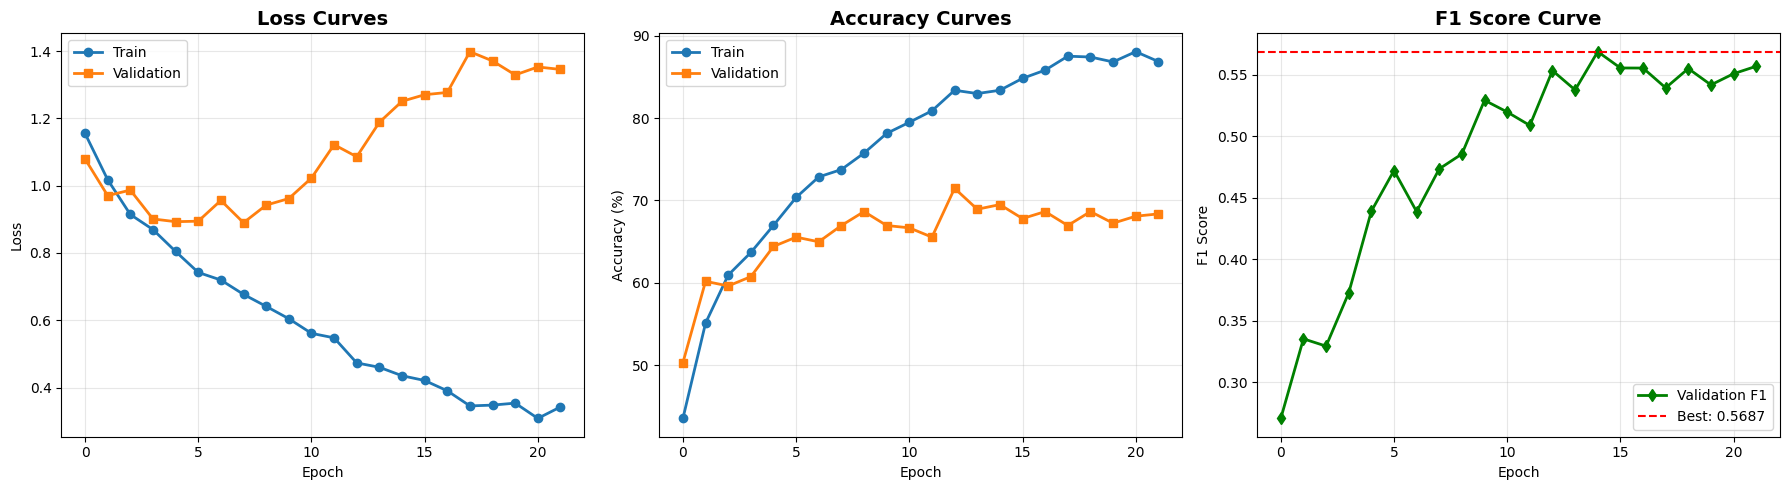

✅ Training curves saved!

✅ Section 4 Complete!


In [16]:
"""
Hybrid Model - Section 4: Training Pipeline
============================================
Complete training with monitoring
"""

print("="*60)
print("🎯 TRAINING CONFIGURATION")
print("="*60)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Training parameters
NUM_EPOCHS = 30
PATIENCE = 7

print(f"Optimizer: Adam")
print(f"Learning Rate: 0.001")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Early Stopping Patience: {PATIENCE}")
print(f"Fusion Type: {FUSION_TYPE}")

print("\n" + "="*60)
print("🚀 TRAINING FUNCTIONS")
print("="*60)

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for lstm_input, gat_input, labels in pbar:
        lstm_input = lstm_input.to(device)
        gat_input = gat_input.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs, _ = model(lstm_input, gat_input)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return total_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for lstm_input, gat_input, labels in pbar:
            lstm_input = lstm_input.to(device)
            gat_input = gat_input.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(lstm_input, gat_input)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(loader), 100. * correct / total, f1, all_preds, all_labels


print("\n" + "="*60)
print("🔥 TRAINING START")
print("="*60)

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0
patience_counter = 0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_f1, val_preds, val_labels = validate(
        model, val_loader, criterion, device
    )
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"\n📊 Results:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
            'val_loss': val_loss,
            'fusion_type': FUSION_TYPE
        }, '../models/hybrid/best_hybrid_model.pth')
        print(f"   ✅ Best model saved! F1: {val_f1:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"   ⏳ Patience: {patience_counter}/{PATIENCE}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
        break

training_time = time.time() - start_time

print(f"\n{'='*60}")
print(f"🎉 TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"⏱️  Total Time: {training_time/60:.2f} minutes")
print(f"🏆 Best Val F1: {best_val_f1:.4f}")
print(f"📊 Best Val Accuracy: {checkpoint['val_acc']:.2f}%" if 'checkpoint' in locals() else "")

# Save training history
with open('../results/reports/hybrid_training_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print(f"\n✅ Training history saved!")

# Plot training curves
print("\n" + "="*60)
print("📈 TRAINING CURVES")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation', marker='s', linewidth=2)
axes[0].set_title('Loss Curves', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Validation', marker='s', linewidth=2)
axes[1].set_title('Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(history['val_f1'], label='Validation F1', marker='d', 
             color='green', linewidth=2)
axes[2].axhline(y=best_val_f1, color='r', linestyle='--', 
                label=f'Best: {best_val_f1:.4f}')
axes[2].set_title('F1 Score Curve', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/hybrid/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved!")

print("\n✅ Section 4 Complete!")
print("="*60)

Evaluation & Model Comparison

📊 FINAL EVALUATION
✅ Best Hybrid Model loaded!
   Epoch: 14
   Val Accuracy: 69.49%
   Val F1: 0.5687
   Fusion Type: attention

🔍 Detailed Evaluation:



CLASSIFICATION REPORT - HYBRID MODEL
              precision    recall  f1-score   support

    conflict     0.2222    0.2857    0.2500         7
    negative     0.7699    0.6692    0.7160       130
     neutral     0.6034    0.5072    0.5512        69
    positive     0.7011    0.8243    0.7578       148

    accuracy                         0.6949       354
   macro avg     0.5742    0.5716    0.5687       354
weighted avg     0.6979    0.6949    0.6921       354


Confusion Matrix:
[[  2   1   1   3]
 [  3  87  11  29]
 [  0  14  35  20]
 [  4  11  11 122]]

📊 Per-Class Metrics:
conflict   - P: 0.2222 | R: 0.2857 | F1: 0.2500 | Support: 7
negative   - P: 0.7699 | R: 0.6692 | F1: 0.7160 | Support: 130
neutral    - P: 0.6034 | R: 0.5072 | F1: 0.5512 | Support: 69
positive   - P: 0.7011 | R: 0.8243 | F1: 0.7578 | Support: 148

📈 VISUALIZATIONS


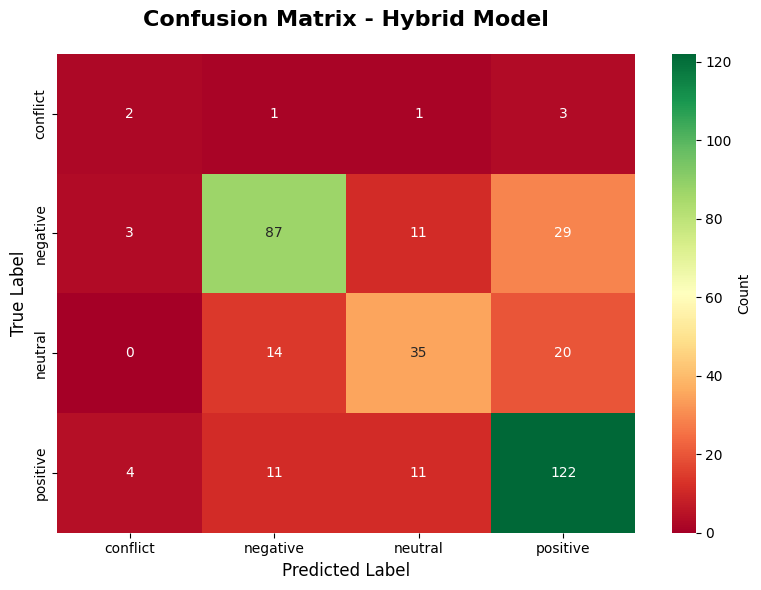

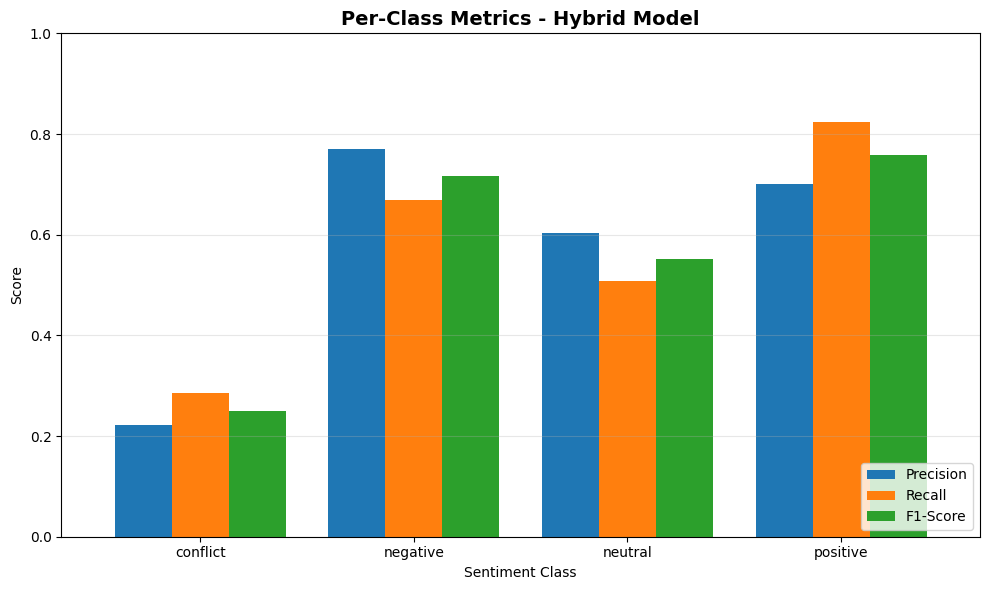


🔥 MODEL COMPARISON: LSTM vs GAT vs HYBRID
✅ LSTM results loaded successfully
✅ GAT results loaded successfully

📊 Complete Model Comparison:
            Model  Accuracy  Macro F1  Conflict F1  Negative F1  Neutral F1  Positive F1
Hybrid (LSTM+GAT) 69.491525  0.568749     0.250000     0.716049    0.551181     0.757764
             LSTM 65.819209  0.524874     0.166667     0.686347    0.516556     0.729927
              GAT 70.056497  0.504110     0.000000     0.744186    0.524590     0.747664

✅ Comparison saved to: model_comparison.csv


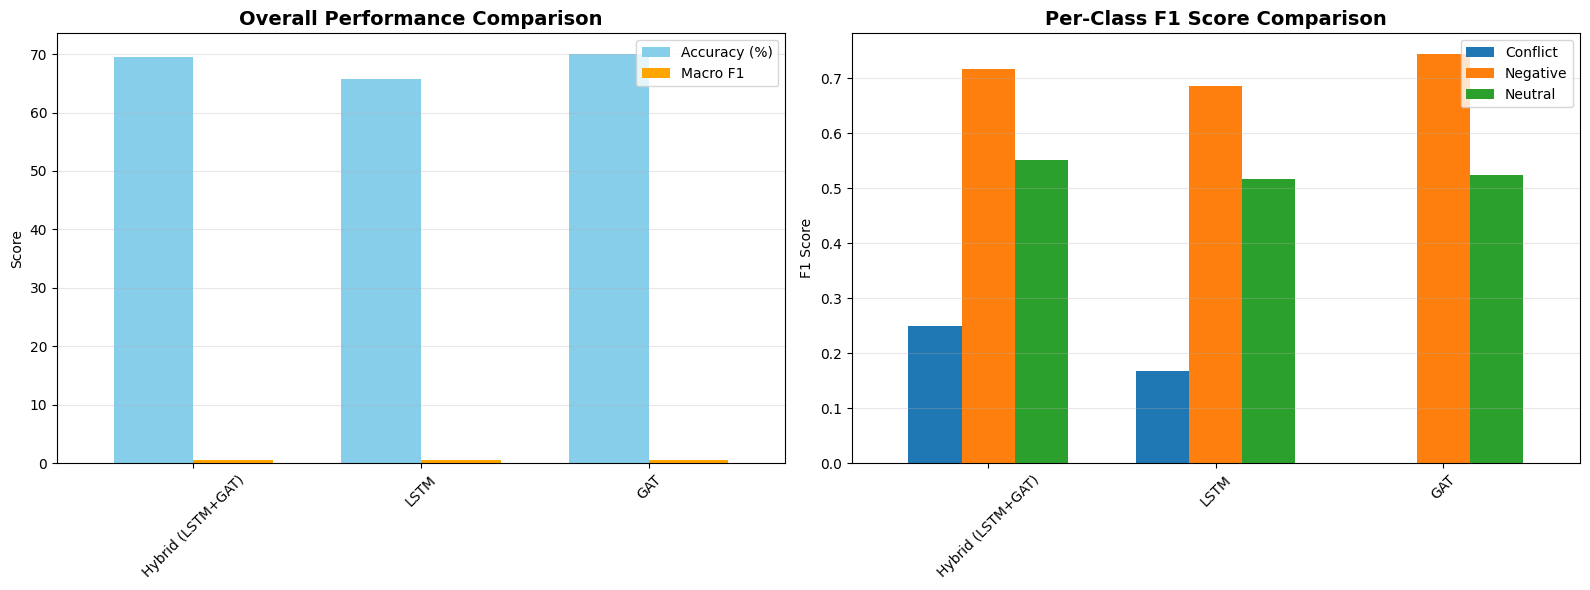

✅ Comparison visualization saved!

🎯 IMPROVEMENT ANALYSIS

📈 Hybrid Model Improvements:

LSTM → Hybrid:
   Accuracy: 65.82% → 69.49% (+3.67%)
   Macro F1: 0.5249 → 0.5687 (+0.0439)

GAT → Hybrid:
   Accuracy: 70.06% → 69.49% (-0.56%)
   Macro F1: 0.5041 → 0.5687 (+0.0646)

💾 SAVE FINAL RESULTS
✅ Results saved!

🎊 ALL RESULTS SUMMARY

📁 Saved Files:
   Models:
      - ../models/hybrid/best_hybrid_model.pth
   Figures:
      - ../results/figures/hybrid/training_curves.png
      - ../results/figures/hybrid/confusion_matrix.png
      - ../results/figures/hybrid/per_class_metrics.png
      - ../results/figures/comparison/model_comparison.png
   Reports:
      - ../results/reports/hybrid_final_results.json
      - ../results/reports/model_comparison.csv

🏆 Best Results:
   Model: Hybrid (LSTM + GAT)
   Fusion: attention
   Accuracy: 69.49%
   Macro F1: 0.5687

🎉 HYBRID MODEL COMPLETE!
🎉 ALL THREE MODELS TRAINED SUCCESSFULLY!

✅ Section 5 Complete!


In [17]:
"""
Hybrid Model - Section 5: Evaluation & Complete Comparison
===========================================================
LSTM vs GAT vs Hybrid comparison (FIXED VERSION)
"""

print("="*60)
print("📊 FINAL EVALUATION")
print("="*60)

# Load best model
checkpoint = torch.load('../models/hybrid/best_hybrid_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Best Hybrid Model loaded!")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Val Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"   Val F1: {checkpoint['val_f1']:.4f}")
print(f"   Fusion Type: {checkpoint['fusion_type']}")

# Detailed evaluation
print("\n🔍 Detailed Evaluation:")
_, val_acc, val_f1, val_preds, val_labels = validate(
    model, val_loader, criterion, device
)

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT - HYBRID MODEL")
print("="*60)
print(classification_report(
    val_labels, val_preds,
    target_names=lstm_label_encoder.classes_,
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
print("\nConfusion Matrix:")
print(cm)

# Per-class metrics
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_scores, support = precision_recall_fscore_support(
    val_labels, val_preds, average=None
)

print("\n📊 Per-Class Metrics:")
for i, label in enumerate(lstm_label_encoder.classes_):
    print(f"{label:10} - P: {precision[i]:.4f} | R: {recall[i]:.4f} | F1: {f1_scores[i]:.4f} | Support: {support[i]}")

print("\n" + "="*60)
print("📈 VISUALIZATIONS")
print("="*60)

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=lstm_label_encoder.classes_,
            yticklabels=lstm_label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Hybrid Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('../results/figures/hybrid/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Per-class metrics comparison
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_scores
}, index=lstm_label_encoder.classes_)

ax = metrics_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Per-Class Metrics - Hybrid Model', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../results/figures/hybrid/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("🔥 MODEL COMPARISON: LSTM vs GAT vs HYBRID")
print("="*60)

# ========================================
# FIXED: Safe loading of previous results
# ========================================

def safe_load_json(filepath):
    """Safely load JSON file"""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"⚠️  File not found: {filepath}")
        return None
    except json.JSONDecodeError:
        print(f"⚠️  Invalid JSON: {filepath}")
        return None

# Initialize comparison data
comparison_data = {
    'Model': [],
    'Accuracy': [],
    'Macro F1': []
}

# Add per-class F1 columns dynamically
for label in lstm_label_encoder.classes_:
    comparison_data[f'{label.capitalize()} F1'] = []

# ========================================
# 1. ADD HYBRID RESULTS (current)
# ========================================
comparison_data['Model'].append('Hybrid (LSTM+GAT)')
comparison_data['Accuracy'].append(float(val_acc))
comparison_data['Macro F1'].append(float(val_f1))

for i, label in enumerate(lstm_label_encoder.classes_):
    comparison_data[f'{label.capitalize()} F1'].append(float(f1_scores[i]))

# ========================================
# 2. LOAD LSTM RESULTS (if available)
# ========================================
lstm_results = safe_load_json('../results/reports/lstm_final_results.json')

if lstm_results:
    try:
        comparison_data['Model'].append('LSTM')
        
        # Handle different possible key names
        if 'test_accuracy' in lstm_results:
            comparison_data['Accuracy'].append(float(lstm_results['test_accuracy']) * 100)
        elif 'accuracy' in lstm_results:
            comparison_data['Accuracy'].append(float(lstm_results['accuracy']))
        else:
            comparison_data['Accuracy'].append(0.0)
        
        if 'test_macro_f1' in lstm_results:
            comparison_data['Macro F1'].append(float(lstm_results['test_macro_f1']))
        elif 'macro_f1' in lstm_results:
            comparison_data['Macro F1'].append(float(lstm_results['macro_f1']))
        else:
            comparison_data['Macro F1'].append(0.0)
        
        # Per-class F1
        if 'per_class_f1' in lstm_results:
            for label in lstm_label_encoder.classes_:
                f1_val = lstm_results['per_class_f1'].get(label, 0.0)
                comparison_data[f'{label.capitalize()} F1'].append(float(f1_val))
        else:
            for label in lstm_label_encoder.classes_:
                comparison_data[f'{label.capitalize()} F1'].append(0.0)
        
        print("✅ LSTM results loaded successfully")
    except Exception as e:
        print(f"⚠️  Error loading LSTM results: {e}")
        # Remove partial data
        for key in comparison_data:
            if len(comparison_data[key]) > len(comparison_data['Model']) - 1:
                comparison_data[key].pop()
else:
    print("⚠️  LSTM results not available")

# ========================================
# 3. LOAD GAT RESULTS (if available)
# ========================================
gat_results = safe_load_json('../results/reports/gat_final_results.json')

if gat_results:
    try:
        comparison_data['Model'].append('GAT')
        
        # Handle different possible key names
        if 'val_accuracy' in gat_results:
            comparison_data['Accuracy'].append(float(gat_results['val_accuracy']))
        elif 'accuracy' in gat_results:
            comparison_data['Accuracy'].append(float(gat_results['accuracy']))
        else:
            comparison_data['Accuracy'].append(0.0)
        
        if 'val_f1_macro' in gat_results:
            comparison_data['Macro F1'].append(float(gat_results['val_f1_macro']))
        elif 'macro_f1' in gat_results:
            comparison_data['Macro F1'].append(float(gat_results['macro_f1']))
        else:
            comparison_data['Macro F1'].append(0.0)
        
        # Per-class F1
        if 'per_class_f1' in gat_results:
            for label in lstm_label_encoder.classes_:
                f1_val = gat_results['per_class_f1'].get(label, 0.0)
                comparison_data[f'{label.capitalize()} F1'].append(float(f1_val))
        else:
            for label in lstm_label_encoder.classes_:
                comparison_data[f'{label.capitalize()} F1'].append(0.0)
        
        print("✅ GAT results loaded successfully")
    except Exception as e:
        print(f"⚠️  Error loading GAT results: {e}")
        # Remove partial data
        for key in comparison_data:
            if len(comparison_data[key]) > len(comparison_data['Model']) - 1:
                comparison_data[key].pop()
else:
    print("⚠️  GAT results not available")

# ========================================
# CREATE COMPARISON DATAFRAME
# ========================================
comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Complete Model Comparison:")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('../results/reports/model_comparison.csv', index=False)
print("\n✅ Comparison saved to: model_comparison.csv")

# ========================================
# VISUALIZATION: Model Comparison
# ========================================
if len(comparison_df) > 1:  # Only plot if we have multiple models
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Overall Metrics Comparison
    overall_metrics = comparison_df[['Model', 'Accuracy', 'Macro F1']].set_index('Model')
    overall_metrics.plot(kind='bar', ax=axes[0], width=0.7, color=['skyblue', 'orange'])
    axes[0].set_title('Overall Performance Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Score')
    axes[0].set_xlabel('')
    axes[0].legend(['Accuracy (%)', 'Macro F1'])
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Per-class F1 Comparison (only first 3 classes to avoid clutter)
    per_class_cols = [col for col in comparison_df.columns if 'F1' in col and col != 'Macro F1'][:3]
    per_class_data = comparison_df[['Model'] + per_class_cols].set_index('Model')
    per_class_data.plot(kind='bar', ax=axes[1], width=0.7)
    axes[1].set_title('Per-Class F1 Score Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_xlabel('')
    axes[1].legend([col.replace(' F1', '') for col in per_class_cols])
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('../results/figures/comparison/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Comparison visualization saved!")
else:
    print("⚠️  Need at least 2 models for comparison plot")

# ========================================
# IMPROVEMENT ANALYSIS
# ========================================
print("\n" + "="*60)
print("🎯 IMPROVEMENT ANALYSIS")
print("="*60)

if len(comparison_df) > 1:
    hybrid_row = comparison_df[comparison_df['Model'] == 'Hybrid (LSTM+GAT)'].iloc[0]
    hybrid_acc = hybrid_row['Accuracy']
    hybrid_f1 = hybrid_row['Macro F1']
    
    print("\n📈 Hybrid Model Improvements:")
    
    for model_name in ['LSTM', 'GAT']:
        model_rows = comparison_df[comparison_df['Model'] == model_name]
        
        if len(model_rows) > 0:
            model_row = model_rows.iloc[0]
            model_acc = model_row['Accuracy']
            model_f1 = model_row['Macro F1']
            
            acc_improvement = hybrid_acc - model_acc
            f1_improvement = hybrid_f1 - model_f1
            
            print(f"\n{model_name} → Hybrid:")
            print(f"   Accuracy: {model_acc:.2f}% → {hybrid_acc:.2f}% "
                  f"({'+' if acc_improvement > 0 else ''}{acc_improvement:.2f}%)")
            print(f"   Macro F1: {model_f1:.4f} → {hybrid_f1:.4f} "
                  f"({'+' if f1_improvement > 0 else ''}{f1_improvement:.4f})")
else:
    print("⚠️  Not enough models for improvement analysis")

# ========================================
# SAVE FINAL RESULTS
# ========================================
print("\n" + "="*60)
print("💾 SAVE FINAL RESULTS")
print("="*60)

hybrid_results = {
    'model': 'Hybrid (LSTM + GAT)',
    'fusion_type': FUSION_TYPE,
    'lstm_vocab_size': len(lstm_word2idx),
    'gat_vocab_size': len(gat_word2idx),
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'num_epochs_trained': len(history['train_loss']),
    'best_epoch': checkpoint['epoch'],
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'val_accuracy': float(val_acc),
    'val_f1_macro': float(val_f1),
    'per_class_precision': {label: float(p) for label, p in zip(lstm_label_encoder.classes_, precision)},
    'per_class_recall': {label: float(r) for label, r in zip(lstm_label_encoder.classes_, recall)},
    'per_class_f1': {label: float(f) for label, f in zip(lstm_label_encoder.classes_, f1_scores)},
    'confusion_matrix': cm.tolist(),
    'training_time_minutes': float(training_time / 60)
}

with open('../results/reports/hybrid_final_results.json', 'w') as f:
    json.dump(hybrid_results, f, indent=4)

print("✅ Results saved!")

print("\n" + "="*60)
print("🎊 ALL RESULTS SUMMARY")
print("="*60)

print("\n📁 Saved Files:")
print("   Models:")
print("      - ../models/hybrid/best_hybrid_model.pth")
print("   Figures:")
print("      - ../results/figures/hybrid/training_curves.png")
print("      - ../results/figures/hybrid/confusion_matrix.png")
print("      - ../results/figures/hybrid/per_class_metrics.png")
print("      - ../results/figures/comparison/model_comparison.png")
print("   Reports:")
print("      - ../results/reports/hybrid_final_results.json")
print("      - ../results/reports/model_comparison.csv")

print("\n🏆 Best Results:")
print(f"   Model: Hybrid (LSTM + GAT)")
print(f"   Fusion: {FUSION_TYPE}")
print(f"   Accuracy: {val_acc:.2f}%")
print(f"   Macro F1: {val_f1:.4f}")

print("\n" + "="*60)
print("🎉 HYBRID MODEL COMPLETE!")
print("🎉 ALL THREE MODELS TRAINED SUCCESSFULLY!")
print("="*60)

print("\n✅ Section 5 Complete!")